This Python file performs predictive analysis on Ryanair Ancillary Revenue Data. The goal is to use 2022 historical 
data to predict the expected revenue for a sample of 2023 flights. I have broken the code into three sections:
1) Importing the Data, Packages, Cleaning and Merging
2) Exploratory Data Analysis/Visualization and Feature Engineering 
3) Training/Testing a Machine Learning Model and Applying it to the validation set 
    
    

In [1]:
############ Begining of the Importation Section ############

In [2]:
###
# The standard packages and configurations
###
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import scipy
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

###
# The sklearn packages for performing the analysis
###

from sklearn import datasets, linear_model, metrics, preprocessing
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import train_test_split as tts 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.decomposition import PCA

In [3]:
original_start_time = time.time()

In [4]:
#Delcare variables for importing
###
#insert your own path where the files live and where you would like output a csv file
###
path = r'C:\Users\michi\Downloads\data\data/'
flight = 'data_flight_20k.csv'
sales = 'data_sales_20k.csv'
validation = 'validation_set.csv'

#Import the three datasets and name them 
flight_df = pd.read_csv(path+flight, sep='\t')
sales_df = pd.read_csv(path+sales, index_col=0)
validation_df = pd.read_csv(path+validation)
flight_df.name = 'Flight Dataset'
sales_df.name = 'Sales Dataset'
validation_df.name = 'Validation Dataset'

In [5]:
backup_sale = sales_df 
backup_flight = flight_df
backup_validation = validation_df

In [6]:
#Create definitions
####################
#simple print dimensionality function
def Dimensionality(x):
    n = x.name
    rows = x.shape[0]
    columns = x.shape[1]
    print("There are ", rows," rows in the dataframe", n)
    print("There are ", columns," columns in the dataframe", n)
    
    
# This funtion takes a feature in our df as input and plots it as a histogram, distribution plot, and a box plot.
# Run this cell so we can use the create_plots function below
def create_plots(variable):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    variable.plot(kind = 'hist')
    plt.title(f'{variable.name} histogram plot')
    
    #mean = variable.describe().mean()
    plt.subplot(1, 3, 2)
    mu, sigma = scipy.stats.norm.fit(variable)
    sns.distplot(variable) 
    #plt.legend({'--': mu, 'sigma': sigma})
    plt.axvline(mu, linestyle = '--', color = 'green', )
    plt.axvline(sigma, linestyle = '--', color = 'red')
    plt.title(f'{variable.name} distribution plot')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(variable)
    plt.title(f'{variable.name} box plot')
    plt.show()

In [7]:
#Clean and transform the datasets

In [8]:
#Let's find some basic information about our datasets, starting with the historical flight dataset 
flight_df.info()
print('------------------------------------------------------')
Dimensionality(flight_df)
print('------------------------------------------------------')
flight_df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   InventoryLegSK          20000 non-null  int64 
 1   CarrierCode             20000 non-null  object
 2   FlightNumber            20000 non-null  int64 
 3   DepartureAirport        20000 non-null  object
 4   ArrivalAirport          20000 non-null  object
 5   DepartureDateTimeLocal  20000 non-null  object
 6   DepartureDateTimeUTC    20000 non-null  object
 7   ArrivalDateTimeLocal    20000 non-null  object
 8   ArrivalDateTimeUTC      20000 non-null  object
 9   ArrivalCountry          20000 non-null  object
 10  DepartureCountry        20000 non-null  object
 11  RouteGroup              20000 non-null  object
 12  Region                  20000 non-null  object
 13  FlightCapacity          20000 non-null  int64 
 14  FlightStatus            19917 non-null  object
dtypes:

InventoryLegSK             0
CarrierCode                0
FlightNumber               0
DepartureAirport           0
ArrivalAirport             0
DepartureDateTimeLocal     0
DepartureDateTimeUTC       0
ArrivalDateTimeLocal       0
ArrivalDateTimeUTC         0
ArrivalCountry             0
DepartureCountry           0
RouteGroup                 0
Region                     0
FlightCapacity             0
FlightStatus              83
dtype: int64

In [9]:
flight_df[flight_df['FlightStatus'].isna()]

,InventoryLegSK,CarrierCode,FlightNumber,DepartureAirport,ArrivalAirport,DepartureDateTimeLocal,DepartureDateTimeUTC,ArrivalDateTimeLocal,ArrivalDateTimeUTC,ArrivalCountry,DepartureCountry,RouteGroup,Region,FlightCapacity,FlightStatus
209,8973245,FR,3186,MAD,MAN,2022-08-29 07:25:00,2022-08-29 05:25:00,2022-08-29 08:55:00,2022-08-29 07:55:00,United Kingdom,Spain,CITY,UK REG CITY,189,NaN
258,9872531,FR,3437,BGY,SOF,2022-04-01 20:10:00,2022-04-01 18:10:00,2022-04-01 23:05:00,2022-04-01 20:05:00,Bulgaria,Italy,CITY,EAST-ESFRIT,197,NaN
477,9502146,FR,5080,AMM,BLQ,2022-06-18 21:10:00,2022-06-18 18:10:00,2022-06-19 00:25:00,2022-06-18 22:25:00,Italy,Jordan,LEISURE,S EUR LEISURE,189,NaN
523,9148058,FR,8662,CGN,PMI,2022-06-26 15:25:00,2022-06-26 13:25:00,2022-06-26 17:40:00,2022-06-26 15:40:00,Spain,Germany,LEISURE,DE LEISURE,189,NaN
548,9509726,FR,6259,PMO,FCO,2022-04-04 19:35:00,2022-04-04 17:35:00,2022-04-04 20:45:00,2022-04-04 18:45:00,Italy,Italy,DOMESTIC,ROM DOM,189,NaN
646,9845175,FR,4602,AGP,BLQ,2022-07-23 14:15:00,2022-07-23 12:15:00,2022-07-23 16:45:00,2022-07-23 14:45:00,Italy,Spain,LEISURE,S EUR LEISURE,189,NaN
882,9025095,FR,7207,PMI,CGN,2022-08-31 08:00:00,2022-08-31 06:00:00,2022-08-31 10:20:00,2022-08-31 08:20:00,Germany,Spain,LEISURE,DE LEISURE,180,NaN
940,9440776,FR,6638,GOA,CRL,2022-04-26 16:30:00,2022-04-26 14:30:00,2022-04-26 18:10:00,2022-04-26 16:10:00,Belgium,Italy,CITY,BENL-FRIT,189,NaN
976,9779997,FR,6708,IBZ,FCO,2022-06-21 17:50:00,2022-06-21 15:50:00,2022-06-21 19:30:00,2022-06-21 17:30:00,Italy,Spain,LEISURE,S EUR LEISURE,189,NaN
1141,8936482,FR,3049,ACE,MAD,2022-04-25 09:15:00,2022-04-25 08:15:00,2022-04-25 12:45:00,2022-04-25 10:45:00,Spain,Spain,DOMESTIC,ES CANARY,189,NaN


In [10]:
flight_df.dropna(inplace=True)
flight_df.count()

InventoryLegSK            19917
CarrierCode               19917
FlightNumber              19917
DepartureAirport          19917
ArrivalAirport            19917
DepartureDateTimeLocal    19917
DepartureDateTimeUTC      19917
ArrivalDateTimeLocal      19917
ArrivalDateTimeUTC        19917
ArrivalCountry            19917
DepartureCountry          19917
RouteGroup                19917
Region                    19917
FlightCapacity            19917
FlightStatus              19917
dtype: int64

In [11]:
cols = set(flight_df.columns) - {'InventoryLegSK','FlightNumber'} 
df1 = flight_df[list(cols)]
df1.describe().T.style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
FlightCapacity,19917.000000,189.354371,3.292167,148.000000,189.000000,189.000000,189.000000,197.000000


In [12]:
#Sales dataset

In [13]:
sales_df.info()
print('------------------------------------------------------')
Dimensionality(sales_df)
print('------------------------------------------------------')
sales_df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 990568 entries, 0 to 4946532
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   InventoryLegSK                990568 non-null  int64  
 1   PurchaseDateSK                986593 non-null  float64
 2   Passenger_UnitsSold           990568 non-null  float64
 3   Priority_Boarding_UnitsSold   987333 non-null  float64
 4   Priority_Boarding_RevenueEUR  987333 non-null  float64
 5   20KG_Bag_UnitsSold            980694 non-null  float64
 6   20KG_Bag_RevenueEUR           980694 non-null  float64
 7   10KG_Bag_UnitsSold            990568 non-null  float64
 8   10KG_Bag_RevenueEUR           990568 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 75.6 MB
------------------------------------------------------
There are  990568  rows in the dataframe Sales Dataset
There are  9  columns in the dataframe Sales Dataset
---------------

InventoryLegSK                     0
PurchaseDateSK                  3975
Passenger_UnitsSold                0
Priority_Boarding_UnitsSold     3235
Priority_Boarding_RevenueEUR    3235
20KG_Bag_UnitsSold              9874
20KG_Bag_RevenueEUR             9874
10KG_Bag_UnitsSold                 0
10KG_Bag_RevenueEUR                0
dtype: int64

In [14]:
sales_df[sales_df['PurchaseDateSK'].isna()] 

,InventoryLegSK,PurchaseDateSK,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR
4526,8917184,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8581,8917467,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9126,8917532,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10392,8917663,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13649,8918021,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4943958,10484095,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4943962,10490814,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4944154,10513626,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4946022,10844176,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
sales_df[sales_df['Priority_Boarding_UnitsSold'].isna()] 

,InventoryLegSK,PurchaseDateSK,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR
61066,8924679,20200706.0,10.0,NaN,NaN,0.0,0.00,0.0,0.00
61067,8924679,20201004.0,2.0,NaN,NaN,0.0,0.00,0.0,0.00
61068,8924679,20210702.0,0.0,NaN,NaN,0.0,0.00,0.0,0.00
61069,8924679,20210725.0,0.0,NaN,NaN,1.0,69.98,0.0,0.00
61070,8924679,20211029.0,4.0,NaN,NaN,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...
4898622,10128101,20220818.0,1.0,NaN,NaN,0.0,0.00,0.0,0.00
4898623,10128101,20220819.0,1.0,NaN,NaN,1.0,39.99,0.0,0.00
4898624,10128101,20220820.0,0.0,NaN,NaN,2.0,119.98,0.0,0.00
4898625,10128101,20220821.0,0.0,NaN,NaN,2.0,119.98,0.0,0.00


In [16]:
sales_df[sales_df['20KG_Bag_UnitsSold'].isna()] 

,InventoryLegSK,PurchaseDateSK,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR
144184,8933495,20220116.0,3.0,0.0,0.0,NaN,NaN,0.0,0.00
144185,8933495,20220124.0,2.0,2.0,12.0,NaN,NaN,1.0,13.63
144186,8933495,20220204.0,2.0,0.0,0.0,NaN,NaN,0.0,0.00
144187,8933495,20220208.0,9.0,0.0,0.0,NaN,NaN,0.0,0.00
144188,8933495,20220220.0,2.0,0.0,0.0,NaN,NaN,0.0,0.00
...,...,...,...,...,...,...,...,...,...
4936832,10146076,20220915.0,0.0,0.0,0.0,NaN,NaN,0.0,0.00
4936833,10146076,20220916.0,5.0,0.0,0.0,NaN,NaN,0.0,0.00
4936834,10146076,20220917.0,3.0,0.0,0.0,NaN,NaN,0.0,0.00
4936835,10146076,20220918.0,2.0,1.0,24.0,NaN,NaN,1.0,26.99


In [17]:
sales_df.dropna(inplace=True)
sales_df['Total_Ancillary_Revenue'] = sales_df['Priority_Boarding_RevenueEUR'] + sales_df['20KG_Bag_RevenueEUR'] + sales_df['10KG_Bag_RevenueEUR']
sales_df.count()

InventoryLegSK                  973484
PurchaseDateSK                  973484
Passenger_UnitsSold             973484
Priority_Boarding_UnitsSold     973484
Priority_Boarding_RevenueEUR    973484
20KG_Bag_UnitsSold              973484
20KG_Bag_RevenueEUR             973484
10KG_Bag_UnitsSold              973484
10KG_Bag_RevenueEUR             973484
Total_Ancillary_Revenue         973484
dtype: int64

In [18]:
cols = set(sales_df.columns) - {'InventoryLegSK','PurchaseDateSK'} 
df1 = sales_df[list(cols)]
df1.describe().T.style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
10KG_Bag_UnitsSold,973484.000000,0.133512,0.570367,0.000000,0.000000,0.000000,0.000000,119.000000
Priority_Boarding_UnitsSold,973484.000000,0.525570,1.146141,0.000000,0.000000,0.000000,1.000000,81.000000
Passenger_UnitsSold,973484.000000,2.841705,2.685848,0.000000,1.000000,2.000000,4.000000,189.000000
Total_Ancillary_Revenue,973484.000000,22.095350,41.475278,0.000000,0.000000,0.000000,29.440000,3730.100000
20KG_Bag_UnitsSold,973484.000000,0.328796,0.942699,0.000000,0.000000,0.000000,0.000000,99.000000
10KG_Bag_RevenueEUR,973484.000000,2.761438,11.702382,0.000000,0.000000,0.000000,0.000000,952.000000
Priority_Boarding_RevenueEUR,973484.000000,8.536406,19.438018,0.000000,0.000000,0.000000,13.000000,1022.000000
20KG_Bag_RevenueEUR,973484.000000,10.797506,30.810518,0.000000,0.000000,0.000000,0.000000,3706.080000


In [19]:
#validation dataset

In [20]:
validation_df.info()
print('------------------------------------------------------')
Dimensionality(validation_df)
print('------------------------------------------------------')
validation_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   InventoryLegSK          1924 non-null   int64 
 1   CarrierCode             1924 non-null   object
 2   FlightNumber            1924 non-null   int64 
 3   DepartureAirport        1924 non-null   object
 4   ArrivalAirport          1924 non-null   object
 5   DepartureDateTimeLocal  1924 non-null   object
 6   DepartureDateTimeUTC    1924 non-null   object
 7   ArrivalDateTimeLocal    1924 non-null   object
 8   ArrivalDateTimeUTC      1924 non-null   object
 9   ArrivalCountry          1924 non-null   object
 10  DepartureCountry        1924 non-null   object
 11  RouteGroup              1924 non-null   object
 12  Region                  1924 non-null   object
 13  FlightCapacity          1924 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 210.6+ KB
--------

InventoryLegSK            0
CarrierCode               0
FlightNumber              0
DepartureAirport          0
ArrivalAirport            0
DepartureDateTimeLocal    0
DepartureDateTimeUTC      0
ArrivalDateTimeLocal      0
ArrivalDateTimeUTC        0
ArrivalCountry            0
DepartureCountry          0
RouteGroup                0
Region                    0
FlightCapacity            0
dtype: int64

In [21]:
#Join the flight data and sales data to have one dataframe 


In [22]:
merged_df = pd.DataFrame()
merged_df = flight_df.merge(sales_df, left_on='InventoryLegSK', right_on='InventoryLegSK')
merged_df = merged_df.groupby(['InventoryLegSK', 'CarrierCode', 'FlightNumber', 'DepartureAirport',
           'ArrivalAirport', 'ArrivalCountry','DepartureDateTimeLocal','DepartureDateTimeUTC',
                                 'ArrivalDateTimeLocal','ArrivalDateTimeUTC',
           'DepartureCountry','RouteGroup', 'Region','FlightCapacity', 'FlightStatus'])[
    ["Passenger_UnitsSold",  'Priority_Boarding_UnitsSold','Priority_Boarding_RevenueEUR','20KG_Bag_UnitsSold','20KG_Bag_RevenueEUR','10KG_Bag_UnitsSold','10KG_Bag_RevenueEUR',"Total_Ancillary_Revenue"]].sum()
merged_df.reset_index(inplace=True)
merged_df.head()

,InventoryLegSK,CarrierCode,FlightNumber,DepartureAirport,ArrivalAirport,ArrivalCountry,DepartureDateTimeLocal,DepartureDateTimeUTC,ArrivalDateTimeLocal,ArrivalDateTimeUTC,DepartureCountry,RouteGroup,Region,FlightCapacity,FlightStatus,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR,Total_Ancillary_Revenue
0,8916784,FR,4007,MAN,ALC,Spain,2022-08-02 06:30:00,2022-08-02 05:30:00,2022-08-02 10:10:00,2022-08-02 08:10:00,United Kingdom,LEISURE,UK REG LEISURE,197,Departed,186.0,35.0,719.10,44.0,2197.62,2.0,56.82,2973.54
1,8916799,FR,9073,MAN,ALC,Spain,2022-05-28 17:10:00,2022-05-28 16:10:00,2022-05-28 20:50:00,2022-05-28 18:50:00,United Kingdom,LEISURE,UK REG LEISURE,189,Departed,189.0,43.0,860.71,35.0,1529.75,3.0,87.99,2478.45
2,8916853,FR,9094,MAN,ALC,Spain,2022-06-23 13:50:00,2022-06-23 12:50:00,2022-06-23 17:30:00,2022-06-23 15:30:00,United Kingdom,LEISURE,UK REG LEISURE,197,Departed,199.0,35.0,630.90,9.0,469.44,19.0,770.69,1871.03
3,8916881,FR,9094,MAN,ALC,Spain,2022-05-25 16:55:00,2022-05-25 15:55:00,2022-05-25 20:35:00,2022-05-25 18:35:00,United Kingdom,LEISURE,UK REG LEISURE,189,Departed,190.0,47.0,776.08,60.0,2124.20,5.0,131.08,3031.36
4,8916940,FR,4007,MAN,ALC,Spain,2022-07-20 06:30:00,2022-07-20 05:30:00,2022-07-20 10:10:00,2022-07-20 08:10:00,United Kingdom,LEISURE,UK REG LEISURE,197,Departed,196.0,44.0,853.34,33.0,1807.49,4.0,113.76,2774.59


In [23]:
#I'll remove the cancelled flights as I am only looking to predict the revenue of departing flights
#However, I'll take note of percentage of cancelled flights and apply it to the predicted Total Ancillary Revenue
print(merged_df['FlightStatus'].value_counts(normalize=True)*100)
merged_df = merged_df[merged_df.FlightStatus != 'Cancelled']
print(merged_df['FlightStatus'].value_counts())

Departed     97.542233
Cancelled     2.457767
Name: FlightStatus, dtype: float64
Departed    15359
Name: FlightStatus, dtype: int64


In [24]:
#Keeping a backup of the merged_df before transformation in section 2 
backup_merged = merged_df

In [25]:
############ Ending of the Importation Section ############

In [26]:
############ Beginning of the EDA and Feature Engineering Section ############

In [27]:
#Exploratory Data Analysis and Feature Engineering Actions to be performed:

# Exploratory Data Analysis and Visualization
    # Departure Time
    # Arrival Time
    # TimeSeries
    # Distribution Plot
    # Heat-Map

# Feature Engineering: Hot Encoding & Label Encoding:
    # Carrier Code
    # Departure / Arrival Airport
    # Departure / Arrival Country
    # Route Group
    # Region
    # Flight Status 


In [28]:
merged_df.head()

,InventoryLegSK,CarrierCode,FlightNumber,DepartureAirport,ArrivalAirport,ArrivalCountry,DepartureDateTimeLocal,DepartureDateTimeUTC,ArrivalDateTimeLocal,ArrivalDateTimeUTC,DepartureCountry,RouteGroup,Region,FlightCapacity,FlightStatus,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR,Total_Ancillary_Revenue
0,8916784,FR,4007,MAN,ALC,Spain,2022-08-02 06:30:00,2022-08-02 05:30:00,2022-08-02 10:10:00,2022-08-02 08:10:00,United Kingdom,LEISURE,UK REG LEISURE,197,Departed,186.0,35.0,719.10,44.0,2197.62,2.0,56.82,2973.54
1,8916799,FR,9073,MAN,ALC,Spain,2022-05-28 17:10:00,2022-05-28 16:10:00,2022-05-28 20:50:00,2022-05-28 18:50:00,United Kingdom,LEISURE,UK REG LEISURE,189,Departed,189.0,43.0,860.71,35.0,1529.75,3.0,87.99,2478.45
2,8916853,FR,9094,MAN,ALC,Spain,2022-06-23 13:50:00,2022-06-23 12:50:00,2022-06-23 17:30:00,2022-06-23 15:30:00,United Kingdom,LEISURE,UK REG LEISURE,197,Departed,199.0,35.0,630.90,9.0,469.44,19.0,770.69,1871.03
3,8916881,FR,9094,MAN,ALC,Spain,2022-05-25 16:55:00,2022-05-25 15:55:00,2022-05-25 20:35:00,2022-05-25 18:35:00,United Kingdom,LEISURE,UK REG LEISURE,189,Departed,190.0,47.0,776.08,60.0,2124.20,5.0,131.08,3031.36
4,8916940,FR,4007,MAN,ALC,Spain,2022-07-20 06:30:00,2022-07-20 05:30:00,2022-07-20 10:10:00,2022-07-20 08:10:00,United Kingdom,LEISURE,UK REG LEISURE,197,Departed,196.0,44.0,853.34,33.0,1807.49,4.0,113.76,2774.59


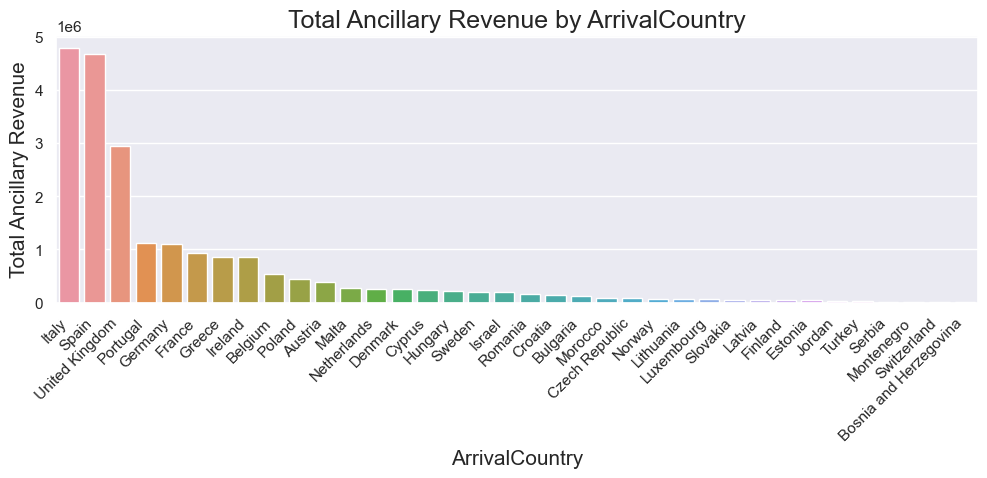

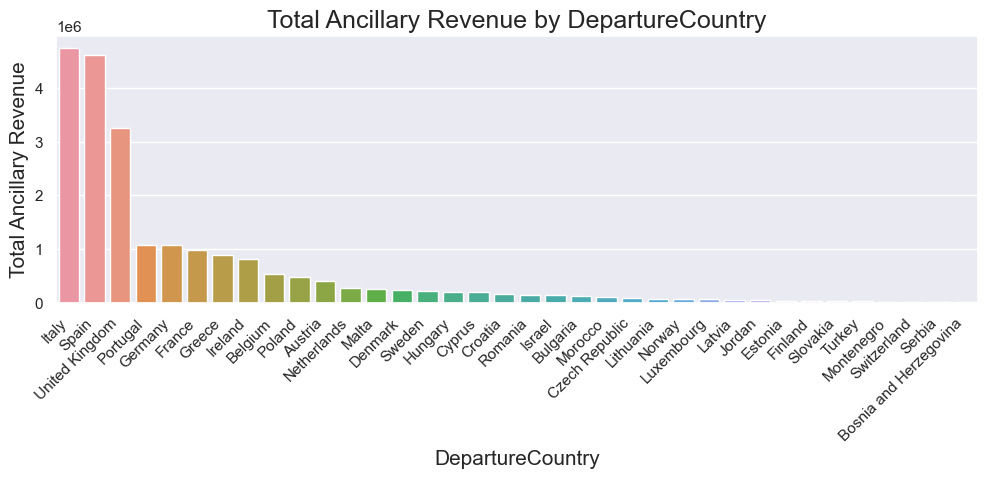

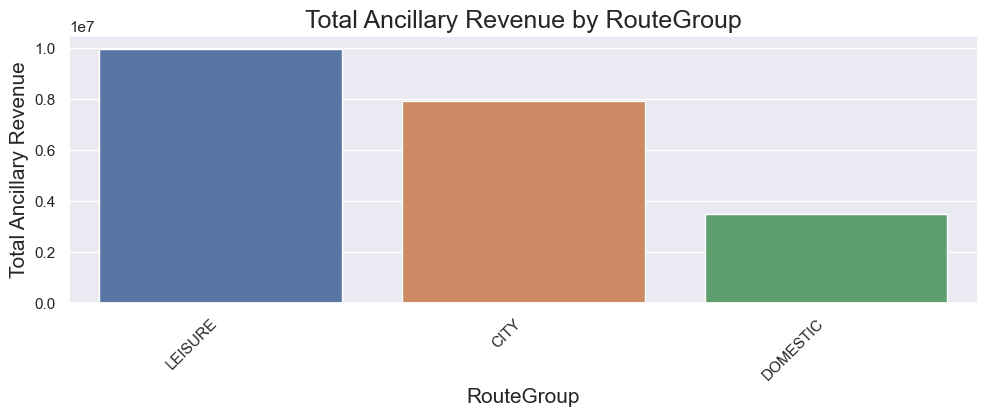

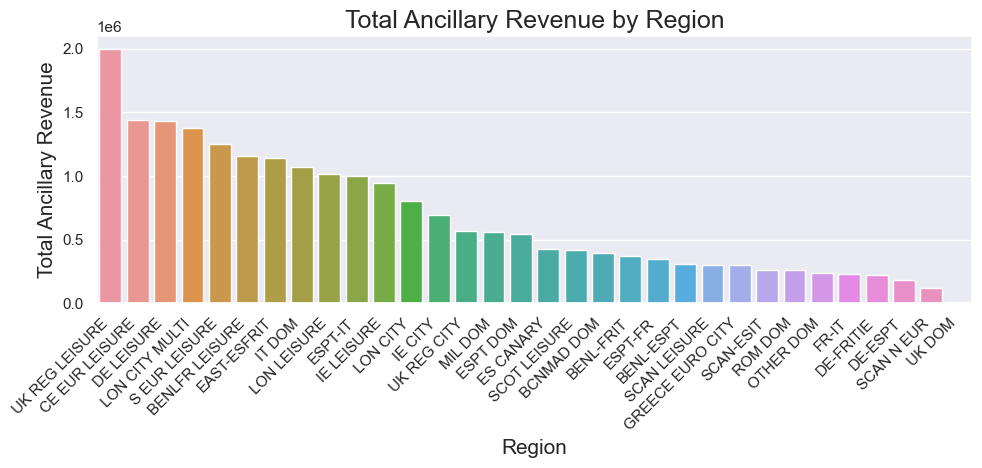

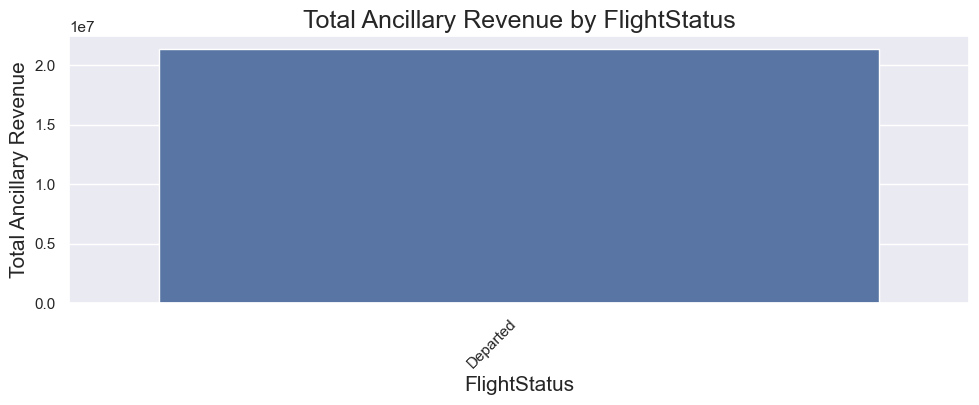

In [29]:
###
#Exploratory Data Analysis and Visualization
#Performing on the categorical data 
###

for i in ['ArrivalCountry','DepartureCountry', 'RouteGroup', 'Region', 'FlightStatus']:

    df2 = merged_df.groupby(i).sum()
    df2.reset_index(inplace=True)
    df2 = df2[[i, 'Total_Ancillary_Revenue']]
    df2 = df2.sort_values('Total_Ancillary_Revenue', ascending = False).reset_index(drop=True)

    plt.figure(figsize=(10,6))
    # make barplot and sort bars
    ax = sns.barplot(x=i, y="Total_Ancillary_Revenue", data=df2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
    plt.tight_layout()
    spacing = 0.500
    plt.subplots_adjust(bottom=spacing)
    # set labels
    plt.xlabel(i, size=15)
    plt.ylabel("Total Ancillary Revenue", size=15)
    plt.title("Total Ancillary Revenue by "+i, size=18)   
    
    plt.show()
    print('\n\n')


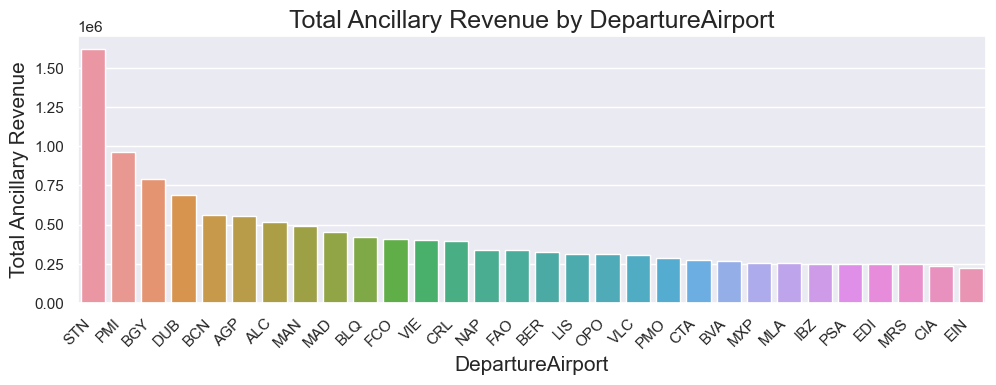

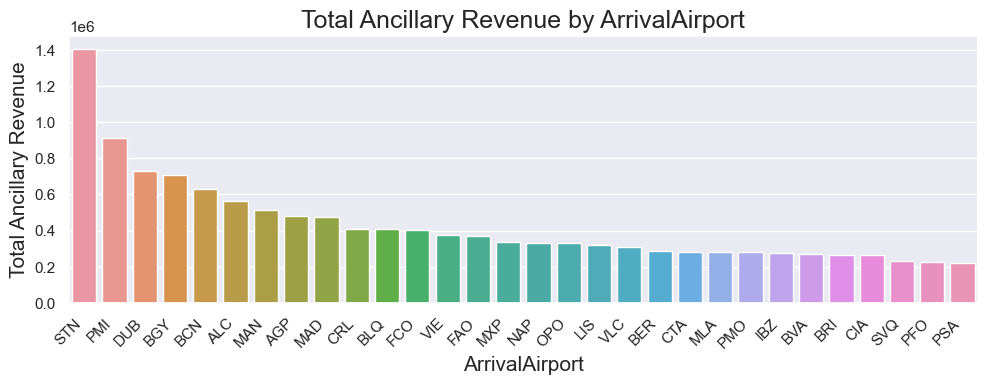

In [30]:
###
# Additional graphs but modified
# The airport graphs are a little too cluttered so I kept the 30 highest aggregated for Total Ancillary Revenue
###

for i in ['DepartureAirport', 'ArrivalAirport']:

    df2 = merged_df.groupby(i).sum()
    df2.reset_index(inplace=True)
    df2 = df2[[i, 'Total_Ancillary_Revenue']]
    df2 = df2.sort_values('Total_Ancillary_Revenue', ascending = False).reset_index(drop=True)
    df2 = df2.head(30)
    
    plt.figure(figsize=(10,6))
    # make barplot and sort bars
    ax = sns.barplot(x=i, y="Total_Ancillary_Revenue", data=df2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
    plt.tight_layout()
    spacing = 0.500
    plt.subplots_adjust(bottom=spacing)
    # set labels
    plt.xlabel(i, size=15)
    plt.ylabel("Total Ancillary Revenue", size=15)
    plt.title("Total Ancillary Revenue by "+i, size=18)   
    
    plt.show()
    print('\n\n')

In [31]:
###
#Simple table to see the counts of flights by departing country 
#Helpful to see the average and lower/upper limits 
#Sorted by highest counts
###
merged_df.groupby('DepartureCountry').describe()['Total_Ancillary_Revenue'].sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
DepartureCountry,,,,,,,,
Italy,4187.0,1131.216835,493.047056,0.00,792.6300,1062.410,1388.3550,4614.11
Spain,3081.0,1494.399873,614.506168,0.00,1062.4800,1443.720,1858.9500,4132.00
United Kingdom,1831.0,1776.221813,763.581732,145.51,1240.6850,1666.080,2202.7200,5308.79
France,824.0,1186.348289,406.922004,0.00,915.8700,1158.650,1447.7625,2949.65
Germany,747.0,1425.692048,537.605707,133.48,1064.5500,1349.840,1684.8900,4042.04
Portugal,710.0,1514.443042,593.830567,160.96,1112.4250,1446.035,1863.1350,3603.03
Ireland,544.0,1493.473217,649.994678,11.50,1077.0725,1436.765,1893.3750,3896.33
Greece,496.0,1780.828790,845.643272,0.00,1235.0350,1687.050,2227.3575,5038.84
Belgium,410.0,1311.738195,517.264430,175.97,944.9375,1258.695,1600.3775,3239.03


In [32]:
###
#Same concepts as previous output but with Arrival Countries
###
merged_df.groupby('ArrivalCountry').describe()['Total_Ancillary_Revenue'].sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ArrivalCountry,,,,,,,,
Italy,4218.0,1135.251162,488.039098,54.00,802.2750,1070.890,1390.7175,5039.51
Spain,3127.0,1500.148609,622.914628,0.00,1066.0450,1437.790,1867.6650,4614.11
United Kingdom,1764.0,1670.456202,754.882342,75.42,1142.3200,1550.245,2074.7750,5038.84
France,797.0,1173.497917,442.741062,97.00,871.3600,1138.260,1436.3000,3013.38
Germany,771.0,1425.860843,497.731643,135.96,1077.8200,1363.780,1703.5100,3243.83
Portugal,718.0,1565.653245,581.938477,325.45,1171.3700,1484.645,1904.7300,3751.89
Ireland,549.0,1547.783989,709.287940,0.00,1061.3600,1470.240,1984.6100,4135.83
Greece,480.0,1797.054333,842.670981,0.00,1250.4150,1656.670,2234.4525,5063.34
Belgium,403.0,1327.542432,526.767381,139.49,968.4500,1271.250,1550.2350,2993.51


Text(0.5, 1.0, 'Ancillary Revenue of Ryanair 2022')

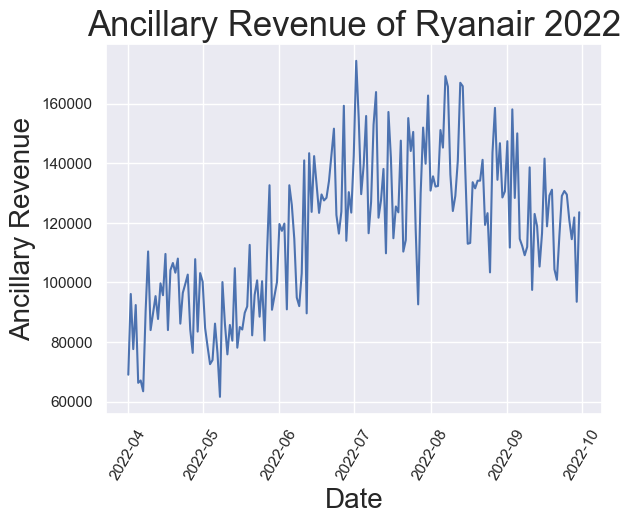

In [33]:
###
#TimeSeries Analysis 
#Plotting the revenue by day for the historical data (2022)
###

###
#create temporary dataset that'll hold the aggregated data by day
temp = merged_df[['DepartureDateTimeLocal', 'Total_Ancillary_Revenue']]
temp['DepartureDateTimeLocal'] = pd.to_datetime(temp.DepartureDateTimeLocal, format='%Y-%m-%d')
temp = temp.groupby([temp['DepartureDateTimeLocal'].dt.date])['Total_Ancillary_Revenue'].sum()
###

###
#Plot the dataframe and add labels
temp.plot(x="DepartureDateTimeLocal", y="Total Ancillary Revenue")
plt.xlabel("Date",  size = 20)
plt.xticks(rotation=60)
plt.ylabel("Ancillary Revenue", size = 20)
plt.title("Ancillary Revenue of Ryanair 2022", size = 25)
###

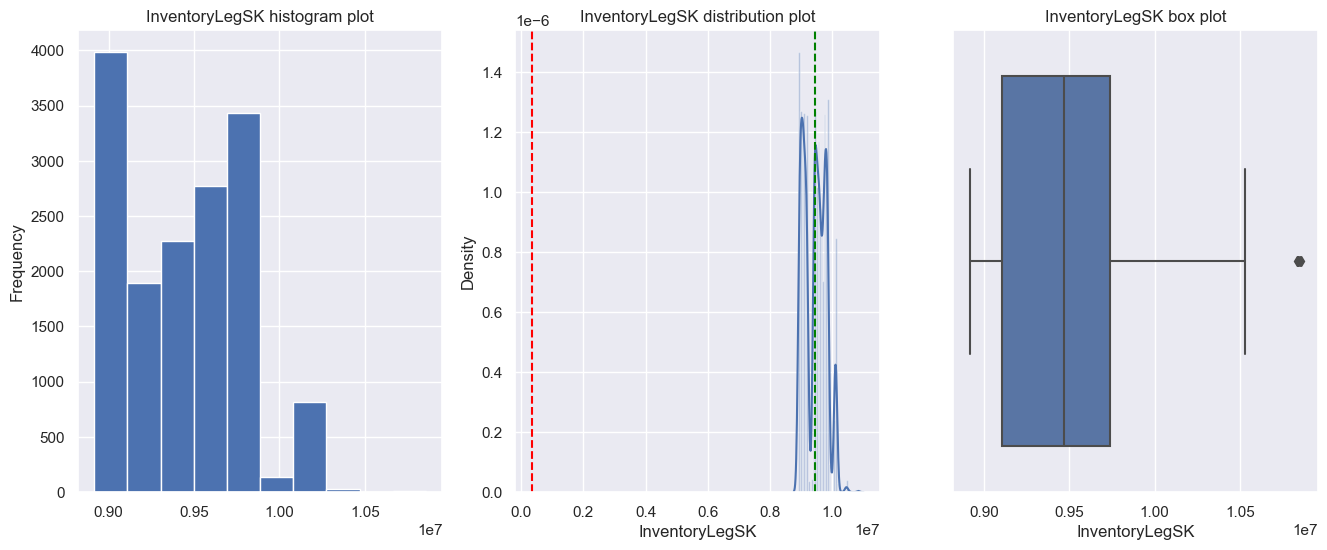

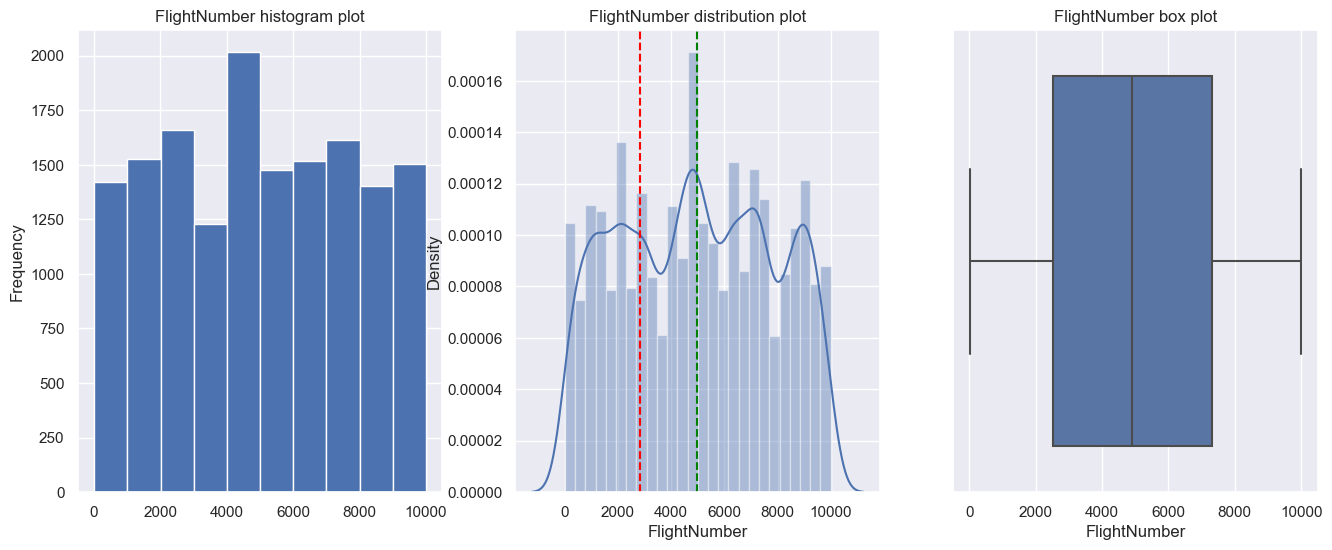

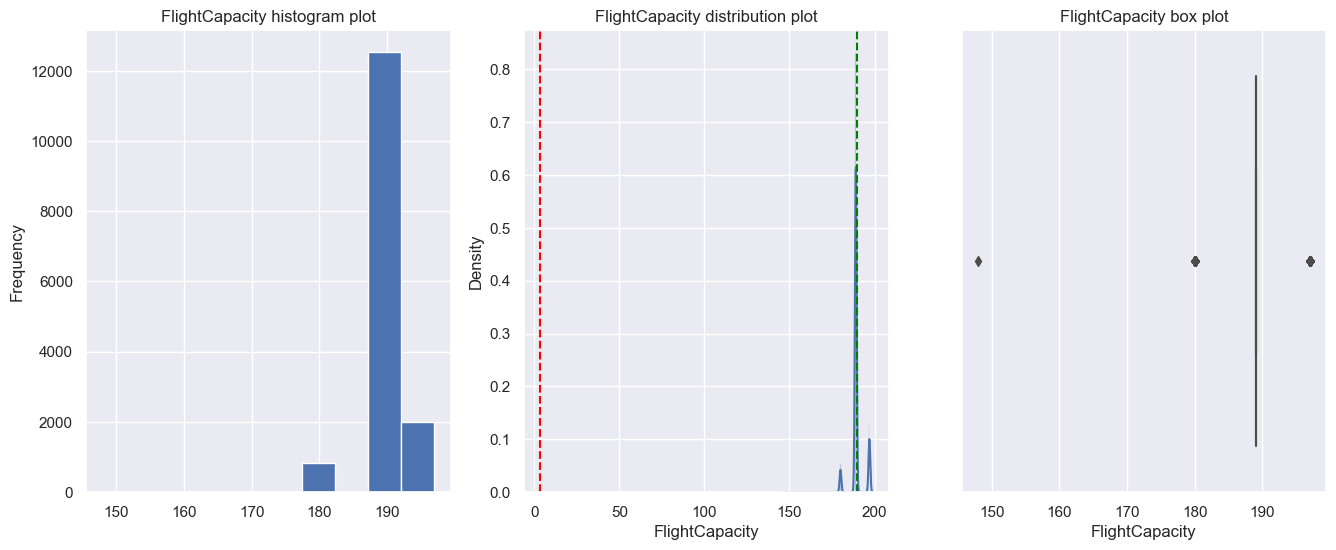

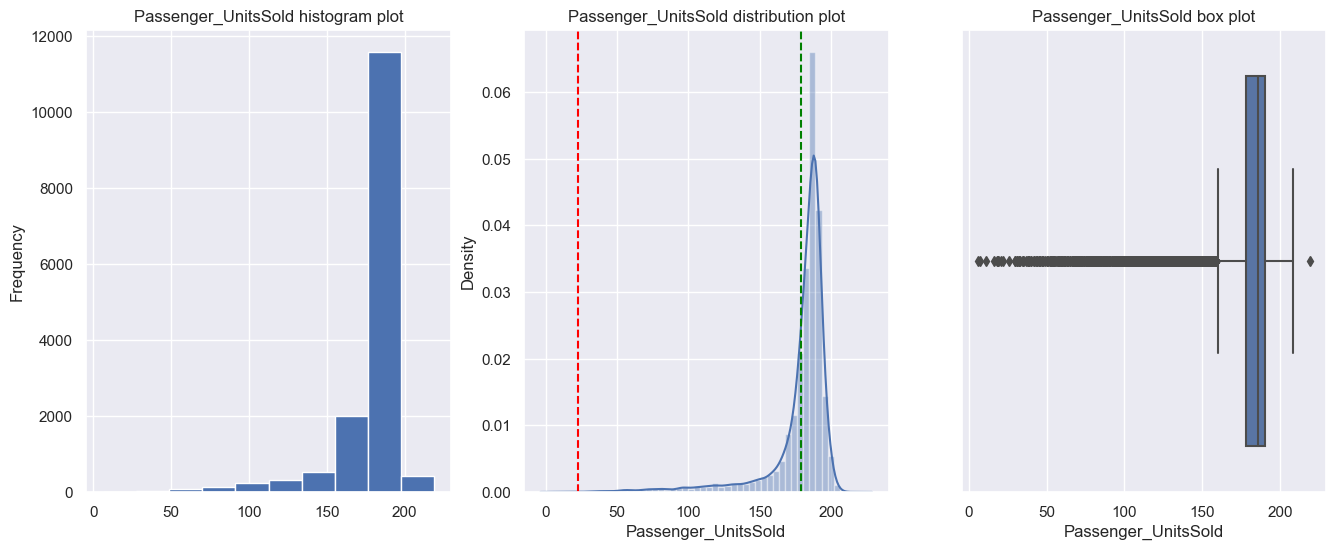

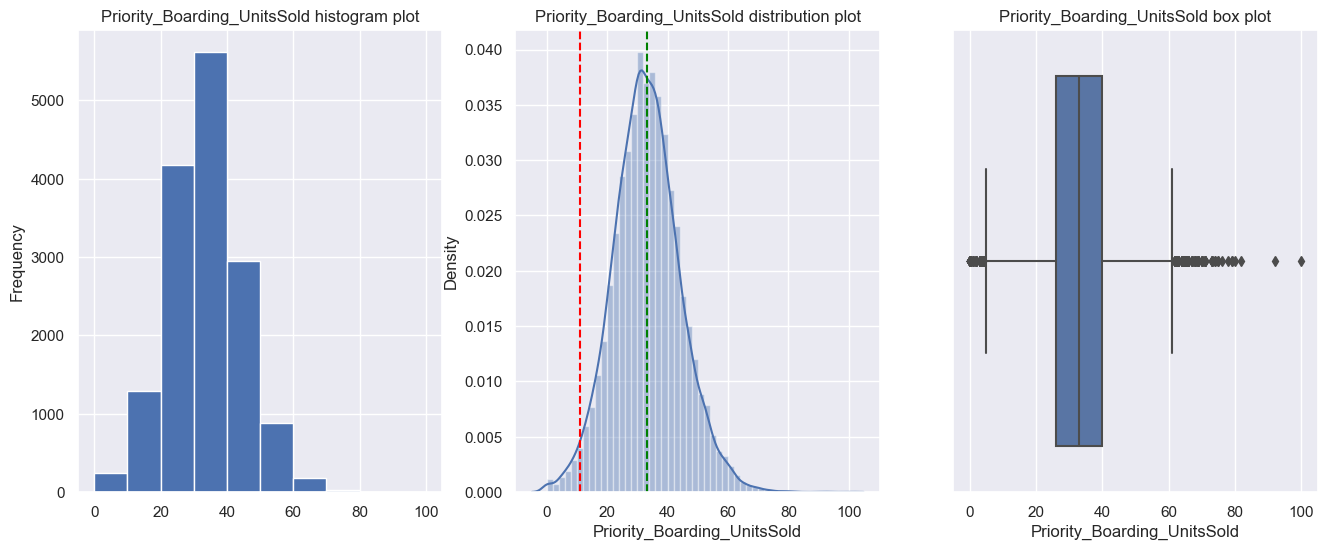

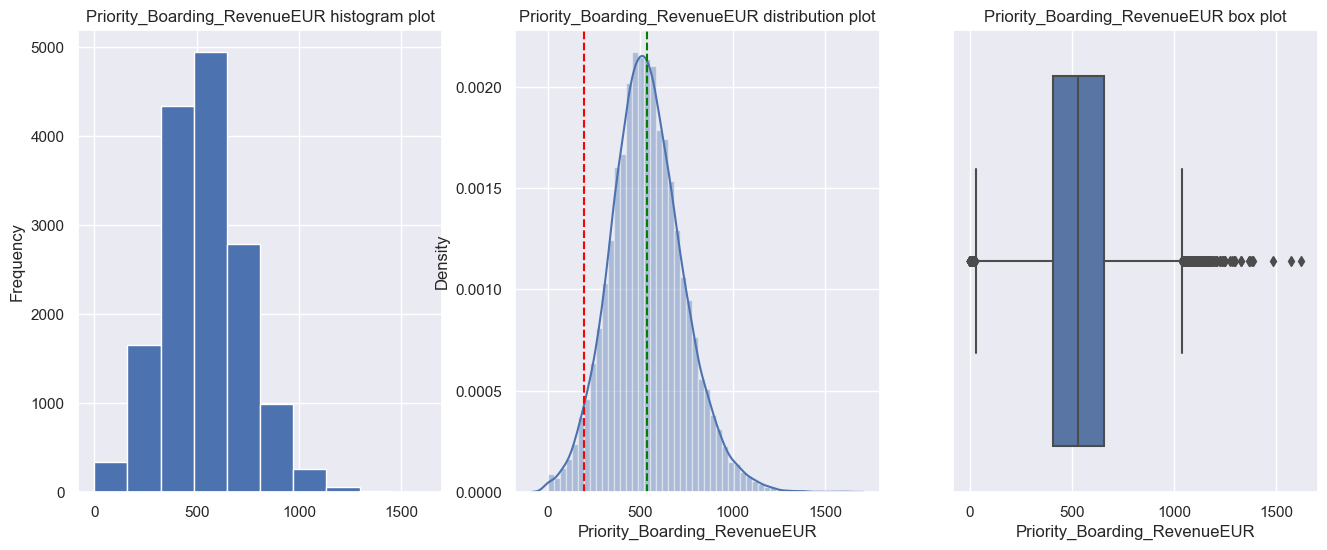

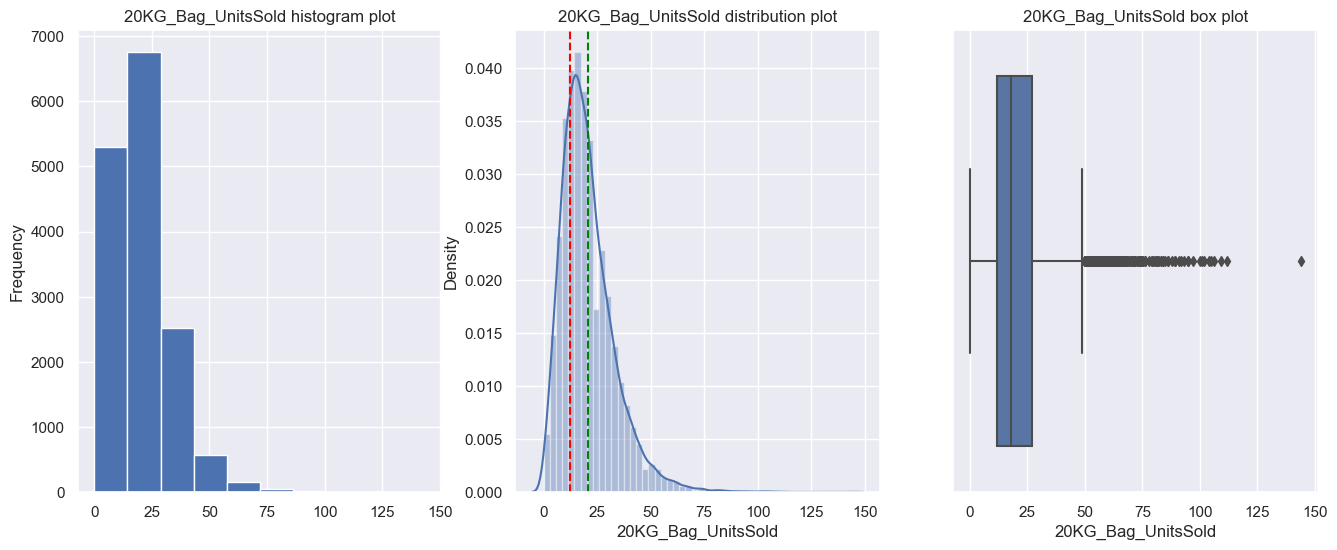

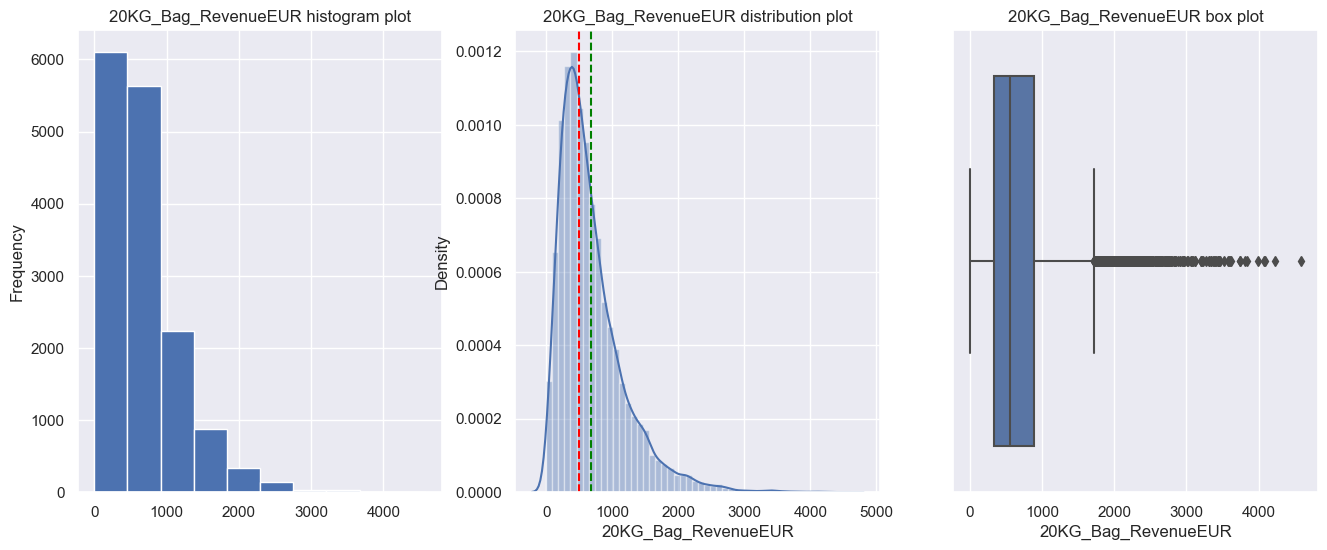

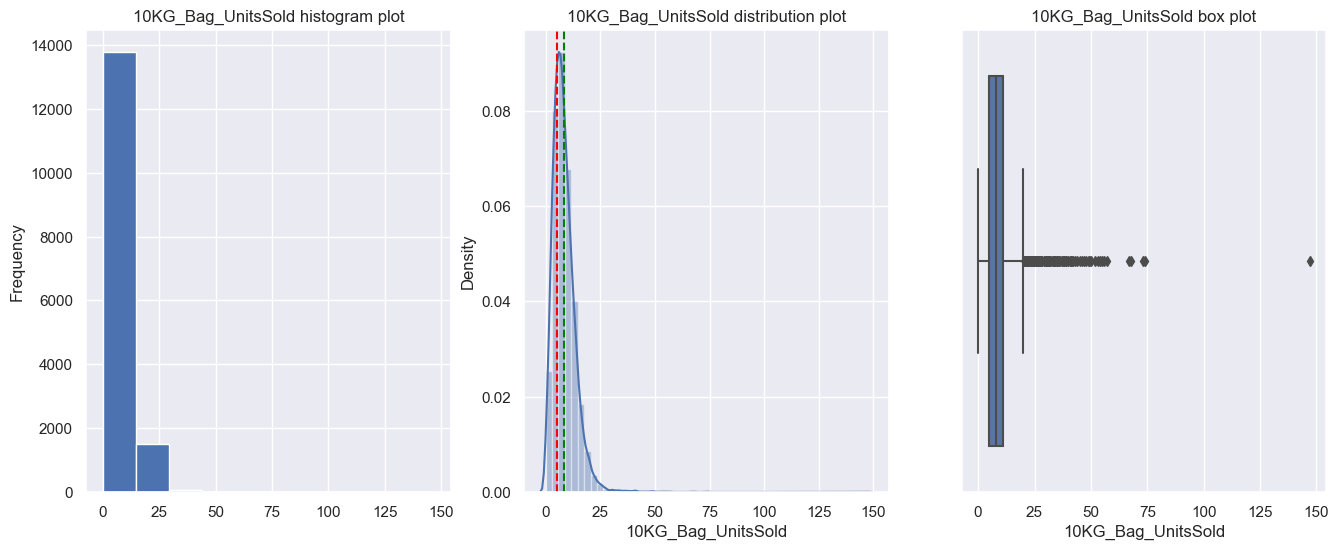

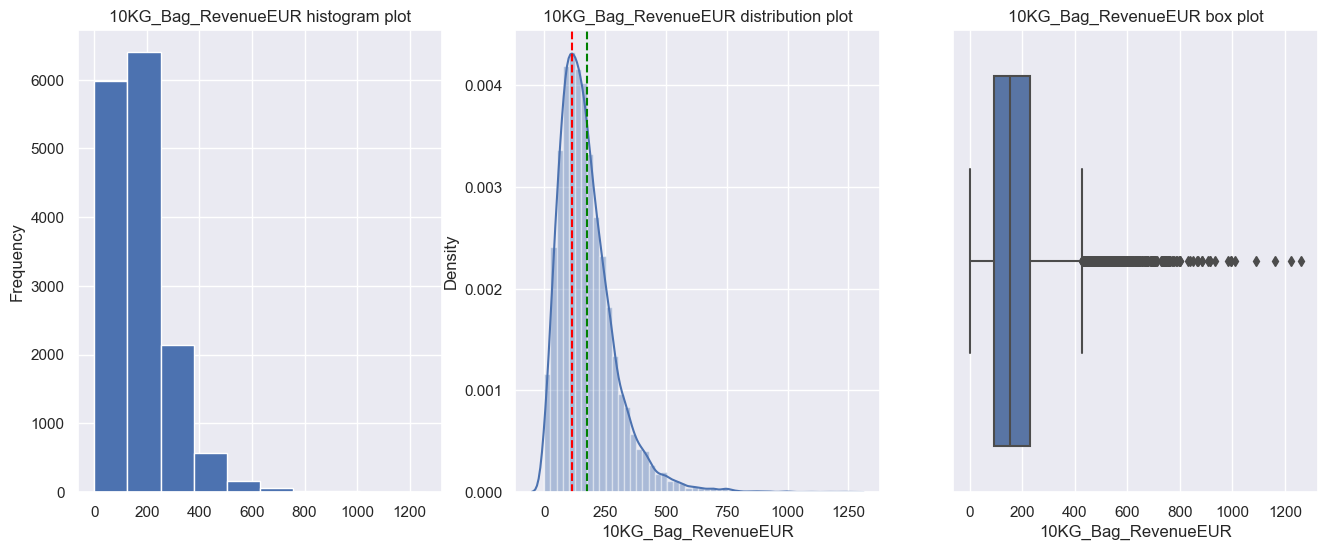

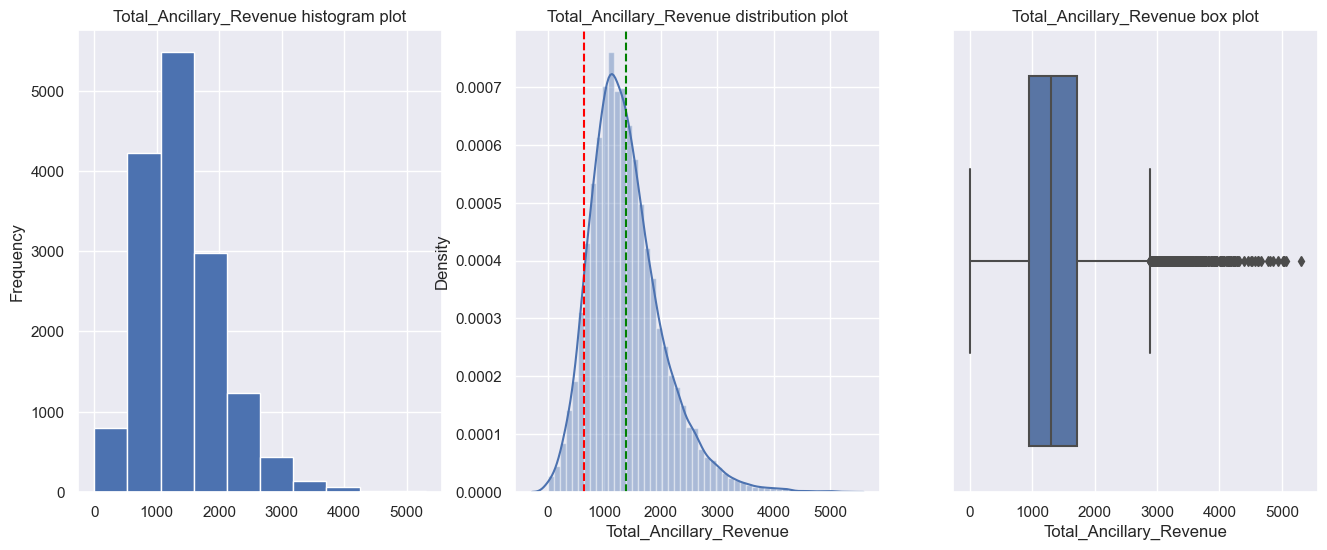

In [34]:
###
# Iterate through the numeric columns to create: Histograms, Distribution and Box Plots 
# red line indicates the mean (mu)
# green line indicates the standard deviation (sigma)
###

merged_df_numeric = merged_df.select_dtypes(include='number')
for col in merged_df_numeric.columns:
    create_plots(merged_df_numeric[col])

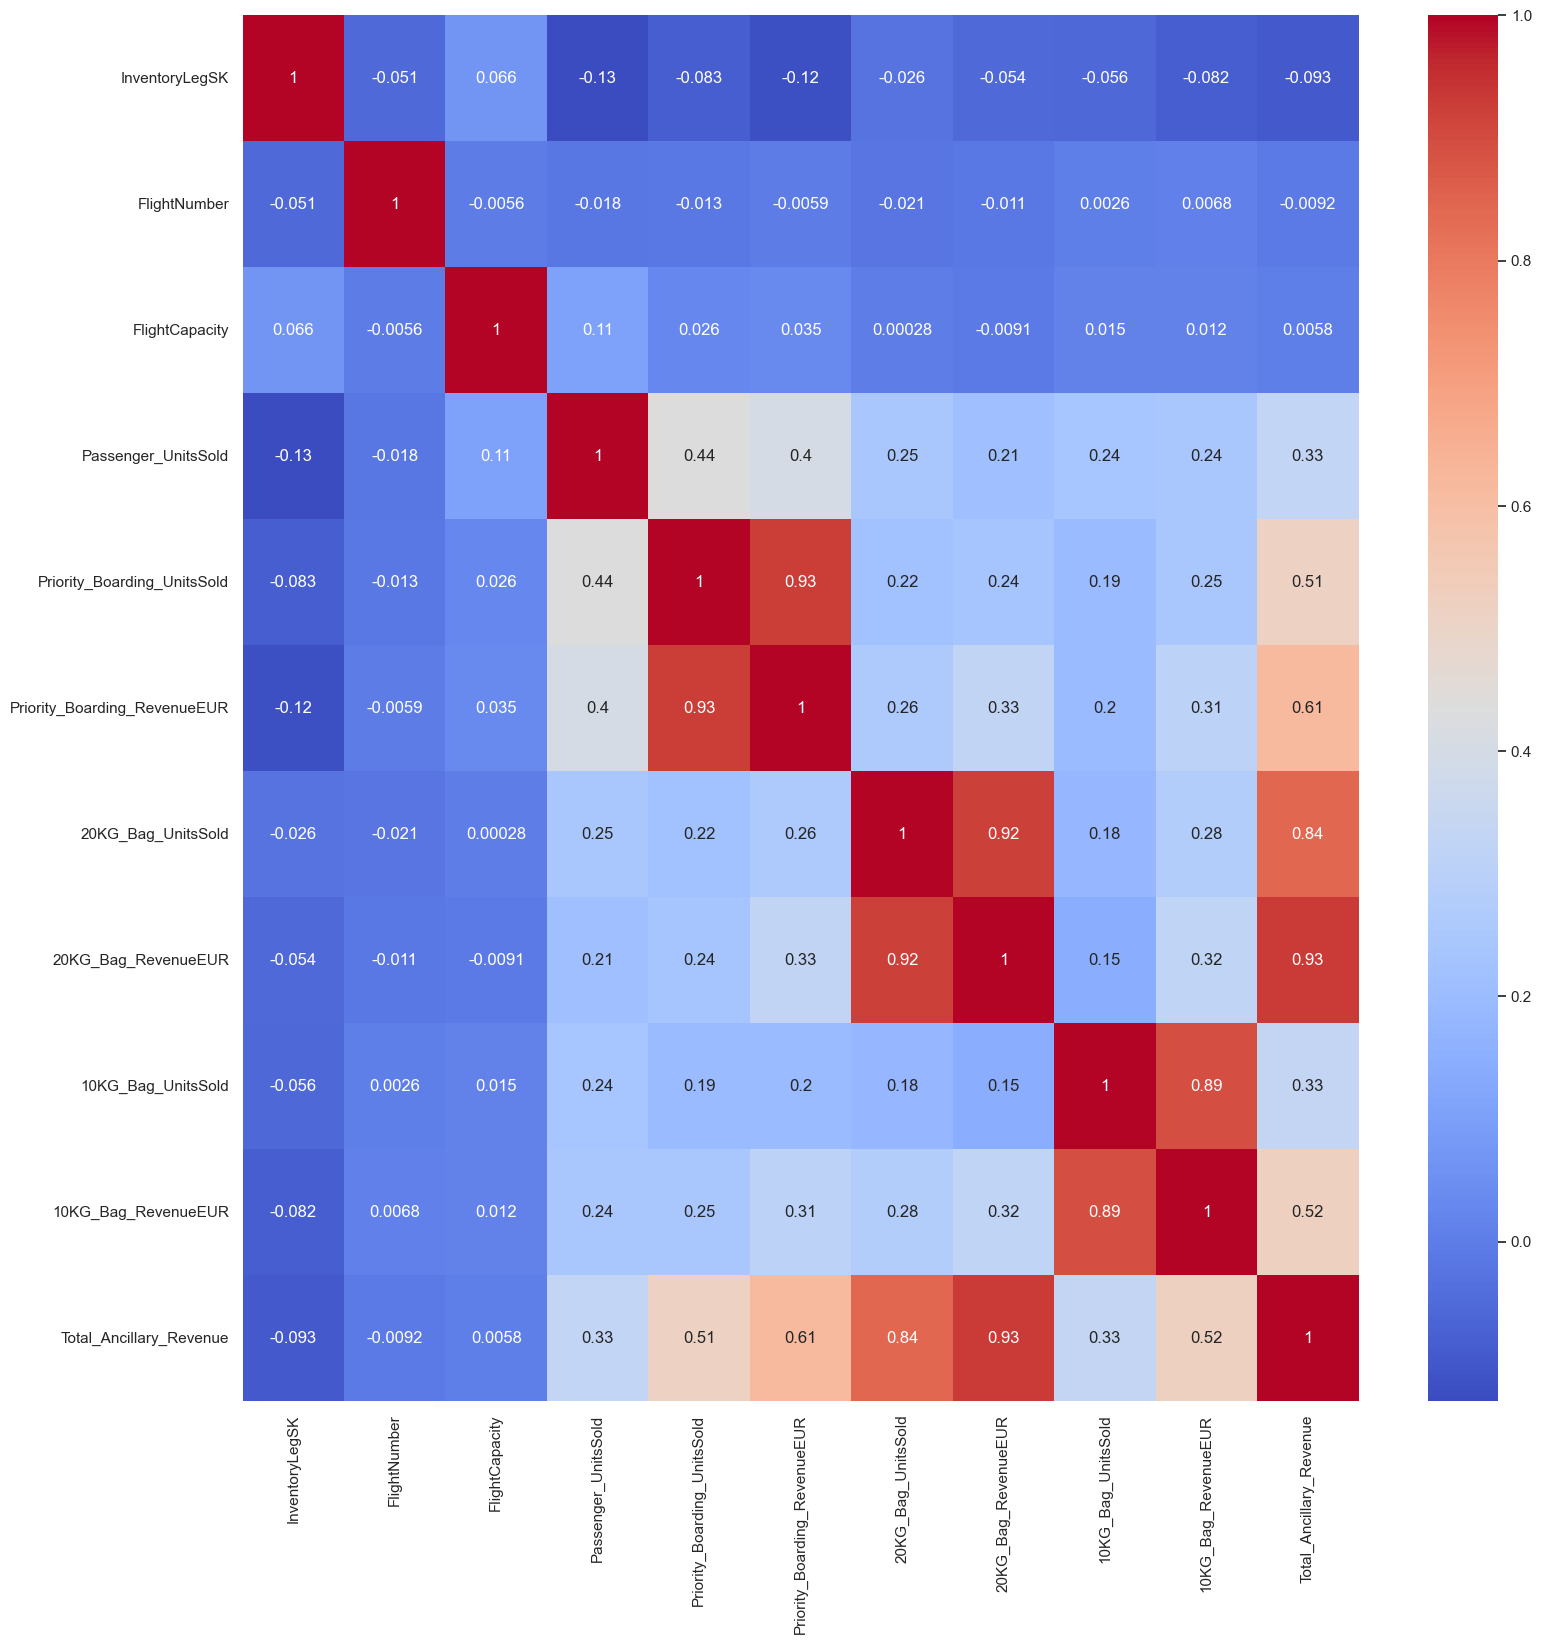

In [35]:
#Correlation Heatmap that is taking considerable time 
plt.figure(figsize = (18,18))
sns.heatmap(merged_df.corr(),annot= True, cmap = "coolwarm")
plt.show()

CARRIER CODE ENCODING

In [36]:
###
# Feature Engineering: Hot Encoding of the merged dataframe (our 2022 data) and the validation dataframe:
# This creates a seprate dataframe of the hot encoding results
###

Carrier = pd.get_dummies(merged_df['CarrierCode'], drop_first=False)
Carrier.head()

CarrierV = pd.get_dummies(validation_df['CarrierCode'], drop_first=False)
CarrierV.head()

,FR,RK
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [37]:
###
#This set we'll join that seperate dataframe with the main dataframes
#Then drop the original column as we'll no longer need it 
###

merged_df = pd.concat([merged_df, Carrier], axis=1)
merged_df.drop('CarrierCode', axis = 1, inplace=True)
merged_df.head()

validation_df = pd.concat([validation_df, CarrierV], axis=1)
validation_df.drop('CarrierCode', axis = 1, inplace=True)
validation_df.head()

,InventoryLegSK,FlightNumber,DepartureAirport,ArrivalAirport,DepartureDateTimeLocal,DepartureDateTimeUTC,ArrivalDateTimeLocal,ArrivalDateTimeUTC,ArrivalCountry,DepartureCountry,RouteGroup,Region,FlightCapacity,FR,RK
0,8916818,9898,LPL,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,1,0
1,8917570,9094,MAN,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,1,0
2,8917600,8296,BRS,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,1,0
3,8917836,7544,MAN,BCN,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,1,0
4,8918208,9898,LPL,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,1,0


In [38]:
###
#removing some unneccesary columns 
#InventoryLegSK is most likely used for database tracking and best practices for storage
#FlightNumber as well is most likely just used for operational and logistical reasons 
#FLightStatus is unncessary as we only have departed flights 
###

merged_df.drop('InventoryLegSK', axis = 1, inplace=True)
merged_df.drop('FlightNumber', axis = 1, inplace=True)
merged_df.drop('FlightStatus', axis = 1, inplace=True)
                            
validation_df.drop('InventoryLegSK', axis = 1, inplace=True)
validation_df.drop('FlightNumber', axis = 1, inplace=True)    

DATES, DURATION, DEPARTURE TIME, ARRIVAL TIME

In [39]:
###
#Modifying the datatime columns. Though it is nice to have 4 columns for it.
#Only one is needed and to split it out to Year, Month, Day, and Day of the week columns
###

###
# Dates
###
merged_df['Year'] = pd.to_datetime(merged_df['DepartureDateTimeUTC']).dt.year
merged_df['Month'] = pd.to_datetime(merged_df['DepartureDateTimeUTC']).dt.month
merged_df['Day'] = pd.to_datetime(merged_df['DepartureDateTimeUTC']).dt.day
merged_df['DayofWeek'] = pd.to_datetime(merged_df['DepartureDateTimeUTC']).dt.weekday
###
# Time 
###
merged_df['DepartingTimeinhours'] =  pd.to_datetime(merged_df['DepartureDateTimeUTC']).dt.hour
merged_df['DepartingTimeinminutes'] =  pd.to_datetime(merged_df['DepartureDateTimeUTC']).dt.minute
merged_df['ArrivalTimeinhours'] =  pd.to_datetime(merged_df['ArrivalDateTimeUTC']).dt.hour
merged_df['ArrivalTimeinminutes'] =  pd.to_datetime(merged_df['ArrivalDateTimeUTC']).dt.minute
merged_df['DurationMinutes'] = (pd.to_datetime(merged_df['ArrivalDateTimeUTC']) - pd.to_datetime(merged_df['DepartureDateTimeUTC'])) / pd.Timedelta(minutes=1)

merged_df.drop(['DepartureDateTimeLocal', 'DepartureDateTimeUTC','ArrivalDateTimeLocal','ArrivalDateTimeUTC'],axis=1, inplace=True)
merged_df.head()

###
#Replicate for valdiation dataframe 
###

###
# Dates
###
validation_df['Year'] = pd.to_datetime(validation_df['DepartureDateTimeUTC']).dt.year
validation_df['Month'] = pd.to_datetime(validation_df['DepartureDateTimeUTC']).dt.month
validation_df['Day'] = pd.to_datetime(validation_df['DepartureDateTimeUTC']).dt.day
validation_df['DayofWeek'] = pd.to_datetime(validation_df['DepartureDateTimeUTC']).dt.weekday
###
# Time
###
validation_df['DepartingTimeinhours'] =  pd.to_datetime(validation_df['DepartureDateTimeUTC']).dt.hour
validation_df['DepartingTimeinminutes'] =  pd.to_datetime(validation_df['DepartureDateTimeUTC']).dt.minute
validation_df['ArrivalTimeinhours'] =  pd.to_datetime(validation_df['ArrivalDateTimeUTC']).dt.hour
validation_df['ArrivalTimeinminutes'] =  pd.to_datetime(validation_df['ArrivalDateTimeUTC']).dt.minute
validation_df['DurationMinutes'] = (pd.to_datetime(validation_df['ArrivalDateTimeUTC']) - pd.to_datetime(validation_df['DepartureDateTimeUTC'])) / pd.Timedelta(minutes=1)

validation_df.drop(['DepartureDateTimeLocal', 'DepartureDateTimeUTC','ArrivalDateTimeLocal','ArrivalDateTimeUTC'],axis=1, inplace=True)

Departure and Arrival Airports

In [40]:
###
#Before splitting out Departure and Arrival Airports curious to what the unique values are and how many are in each 
###

list1 = ['DepartureAirport','ArrivalAirport']
for l in list1:
    print(merged_df[[l]].value_counts(), '\n')

DepartureAirport
STN                 987
BGY                 682
PMI                 600
DUB                 459
BCN                 407
FCO                 343
BLQ                 342
ALC                 329
MAD                 319
AGP                 316
CRL                 306
VIE                 275
PMO                 268
NAP                 261
CTA                 254
OPO                 251
MAN                 242
VLC                 233
MXP                 230
PSA                 216
BRI                 210
BVA                 209
MRS                 207
BER                 207
LIS                 198
FAO                 188
CIA                 173
CAG                 170
VCE                 165
MLA                 160
BUD                 160
IBZ                 156
EIN                 154
EDI                 142
BDS                 141
TSF                 141
SVQ                 136
ARN                 120
TRN                 120
CGN                 116
SKG                 107

In [41]:
###
#Hot encoding for Departure and Arrival Airports
###
merged_df = pd.get_dummies(data=merged_df, columns = list1, drop_first=False)
merged_df.head()

validation_df = pd.get_dummies(data=validation_df, columns = list1, drop_first=False)
validation_df.head()


,ArrivalCountry,DepartureCountry,RouteGroup,Region,FlightCapacity,FR,RK,Year,Month,Day,DayofWeek,DepartingTimeinhours,DepartingTimeinminutes,ArrivalTimeinhours,ArrivalTimeinminutes,DurationMinutes,DepartureAirport_AAL,DepartureAirport_AAR,DepartureAirport_ABZ,DepartureAirport_ACE,DepartureAirport_AGA,DepartureAirport_AGP,DepartureAirport_AHO,DepartureAirport_ALC,DepartureAirport_AMM,DepartureAirport_AOI,DepartureAirport_ARN,DepartureAirport_ATH,DepartureAirport_BCN,DepartureAirport_BDS,DepartureAirport_BER,DepartureAirport_BGY,DepartureAirport_BHX,DepartureAirport_BIQ,DepartureAirport_BJV,DepartureAirport_BLL,DepartureAirport_BLQ,DepartureAirport_BOD,DepartureAirport_BOJ,DepartureAirport_BRE,DepartureAirport_BRI,DepartureAirport_BRS,DepartureAirport_BRU,DepartureAirport_BSL,DepartureAirport_BTS,DepartureAirport_BUD,DepartureAirport_BVA,DepartureAirport_BVE,DepartureAirport_BZR,DepartureAirport_CAG,DepartureAirport_CCF,DepartureAirport_CFU,DepartureAirport_CGN,DepartureAirport_CHQ,DepartureAirport_CIA,DepartureAirport_CIY,DepartureAirport_CPH,DepartureAirport_CRL,DepartureAirport_CRV,DepartureAirport_CTA,DepartureAirport_CUF,DepartureAirport_CWL,DepartureAirport_DLE,DepartureAirport_DRS,DepartureAirport_DTM,DepartureAirport_DUB,DepartureAirport_EDI,DepartureAirport_EFL,DepartureAirport_EGC,DepartureAirport_EIN,DepartureAirport_EMA,DepartureAirport_FAO,DepartureAirport_FCO,DepartureAirport_FKB,DepartureAirport_FMM,DepartureAirport_FMO,DepartureAirport_FNC,DepartureAirport_FNI,DepartureAirport_FRL,DepartureAirport_FSC,DepartureAirport_FUE,DepartureAirport_GDN,DepartureAirport_GLA,DepartureAirport_GOA,DepartureAirport_GOT,DepartureAirport_GRO,DepartureAirport_HAM,DepartureAirport_HEL,DepartureAirport_HER,DepartureAirport_HHN,DepartureAirport_IBZ,DepartureAirport_JMK,DepartureAirport_JSI,DepartureAirport_KIR,DepartureAirport_KRK,DepartureAirport_KTW,DepartureAirport_KUN,DepartureAirport_LBA,DepartureAirport_LCA,DepartureAirport_LEI,DepartureAirport_LIG,DepartureAirport_LIL,DepartureAirport_LIS,DepartureAirport_LLA,DepartureAirport_LPA,DepartureAirport_LPL,DepartureAirport_LPP,DepartureAirport_LRH,DepartureAirport_LTN,DepartureAirport_LUX,DepartureAirport_MAD,DepartureAirport_MAH,DepartureAirport_MAN,DepartureAirport_MLA,DepartureAirport_MMX,DepartureAirport_MRS,DepartureAirport_MXP,DepartureAirport_NAP,DepartureAirport_NCE,DepartureAirport_NCL,DepartureAirport_NOC,DepartureAirport_NRN,DepartureAirport_NTE,DepartureAirport_NUE,DepartureAirport_OPO,DepartureAirport_ORK,DepartureAirport_OTP,DepartureAirport_PDL,DepartureAirport_PEG,DepartureAirport_PFO,DepartureAirport_PGF,DepartureAirport_PIS,DepartureAirport_PMI,DepartureAirport_PMO,DepartureAirport_POZ,DepartureAirport_PRG,DepartureAirport_PSA,DepartureAirport_PSR,DepartureAirport_PVK,DepartureAirport_RAK,DepartureAirport_RBA,DepartureAirport_REU,DepartureAirport_RHO,DepartureAirport_RIX,DepartureAirport_RMI,DepartureAirport_RMU,DepartureAirport_SBZ,DepartureAirport_SCQ,DepartureAirport_SCV,DepartureAirport_SDR,DepartureAirport_SKG,DepartureAirport_SNN,DepartureAirport_SOF,DepartureAirport_SPC,DepartureAirport_STN,DepartureAirport_SUF,DepartureAirport_SVQ,DepartureAirport_SZZ,DepartureAirport_TFN,DepartureAirport_TFS,DepartureAirport_TGD,DepartureAirport_TLL,DepartureAirport_TLS,DepartureAirport_TLV,DepartureAirport_TNG,DepartureAirport_TPS,DepartureAirport_TRF,DepartureAirport_TRN,DepartureAirport_TRS,DepartureAirport_TSF,DepartureAirport_VCE,DepartureAirport_VIE,DepartureAirport_VLC,DepartureAirport_VNO,DepartureAirport_VRN,DepartureAirport_VST,DepartureAirport_VXO,DepartureAirport_WMI,DepartureAirport_WRO,DepartureAirport_XRY,DepartureAirport_ZAD,DepartureAirport_ZAG,DepartureAirport_ZAZ,DepartureAirport_ZTH,ArrivalAirport_AAL,ArrivalAirport_AAR,ArrivalAirport_ABZ,ArrivalAirport_ACE,ArrivalAirport_AGP,ArrivalAirport_AHO,ArrivalAirport_ALC,ArrivalAirport_AMM,ArrivalAirport_AMS,ArrivalAirport_ARN,ArrivalAirport_ATH,ArrivalAirport_BCN,ArrivalAirport_BDS,ArrivalAirport_BER,ArrivalAi

#Departure and Arrival Countries

In [42]:
###
#Same concept as before curious for the make up of the Departure and Arrival Country values
###
list2 = ['DepartureCountry','ArrivalCountry']
for l in list2:
    print(merged_df[[l]].value_counts(), '\n')

DepartureCountry      
Italy                     4187
Spain                     3081
United Kingdom            1831
France                     824
Germany                    747
Portugal                   710
Ireland                    544
Greece                     496
Belgium                    410
Poland                     382
Austria                    277
Sweden                     208
Netherlands                196
Denmark                    185
Hungary                    160
Malta                      160
Croatia                    139
Romania                    131
Cyprus                     103
Bulgaria                    98
Czech Republic              65
Israel                      59
Luxembourg                  56
Lithuania                   48
Norway                      46
Latvia                      43
Morocco                     37
Slovakia                    30
Finland                     27
Estonia                     25
Jordan                      22
Montenegro      

In [43]:
###
#Hot encoding for the departure and arrival countries
###
validation_df = pd.get_dummies(data=validation_df, columns = list2, drop_first=False)
validation_df.head()

merged_df = pd.get_dummies(data=merged_df, columns = list2, drop_first=False)
merged_df.head()

,RouteGroup,Region,FlightCapacity,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR,Total_Ancillary_Revenue,FR,RK,RR,Year,Month,Day,DayofWeek,DepartingTimeinhours,DepartingTimeinminutes,ArrivalTimeinhours,ArrivalTimeinminutes,DurationMinutes,DepartureAirport_AAL,DepartureAirport_AAR,DepartureAirport_ABZ,DepartureAirport_ACE,DepartureAirport_AGA,DepartureAirport_AGP,DepartureAirport_AHO,DepartureAirport_ALC,DepartureAirport_AMM,DepartureAirport_AMS,DepartureAirport_AOI,DepartureAirport_ARN,DepartureAirport_ATH,DepartureAirport_BCN,DepartureAirport_BDS,DepartureAirport_BER,DepartureAirport_BGY,DepartureAirport_BHX,DepartureAirport_BIQ,DepartureAirport_BJV,DepartureAirport_BLL,DepartureAirport_BLQ,DepartureAirport_BNX,DepartureAirport_BOD,DepartureAirport_BOH,DepartureAirport_BOJ,DepartureAirport_BRE,DepartureAirport_BRI,DepartureAirport_BRS,DepartureAirport_BRU,DepartureAirport_BSL,DepartureAirport_BTS,DepartureAirport_BUD,DepartureAirport_BVA,DepartureAirport_BVE,DepartureAirport_BZR,DepartureAirport_CAG,DepartureAirport_CCF,DepartureAirport_CDT,DepartureAirport_CFE,DepartureAirport_CFU,DepartureAirport_CGN,DepartureAirport_CHQ,DepartureAirport_CIA,DepartureAirport_CIY,DepartureAirport_CPH,DepartureAirport_CRL,DepartureAirport_CRV,DepartureAirport_CTA,DepartureAirport_CUF,DepartureAirport_CWL,DepartureAirport_DBV,DepartureAirport_DLE,DepartureAirport_DLM,DepartureAirport_DRS,DepartureAirport_DTM,DepartureAirport_DUB,DepartureAirport_EDI,DepartureAirport_EFL,DepartureAirport_EGC,DepartureAirport_EIN,DepartureAirport_EMA,DepartureAirport_FAO,DepartureAirport_FCO,DepartureAirport_FEZ,DepartureAirport_FKB,DepartureAirport_FMM,DepartureAirport_FMO,DepartureAirport_FNC,DepartureAirport_FNI,DepartureAirport_FSC,DepartureAirport_FUE,DepartureAirport_GDN,DepartureAirport_GLA,DepartureAirport_GOA,DepartureAirport_GOT,DepartureAirport_GRO,DepartureAirport_HAM,DepartureAirport_HAU,DepartureAirport_HEL,DepartureAirport_HER,DepartureAirport_HHN,DepartureAirport_IBZ,DepartureAirport_INI,DepartureAirport_JMK,DepartureAirport_JSI,DepartureAirport_JTR,DepartureAirport_KGS,DepartureAirport_KIR,DepartureAirport_KLX,DepartureAirport_KRK,DepartureAirport_KTW,DepartureAirport_KUN,DepartureAirport_LBA,DepartureAirport_LCA,DepartureAirport_LDE,DepartureAirport_LDY,DepartureAirport_LEI,DepartureAirport_LGW,DepartureAirport_LIG,DepartureAirport_LIL,DepartureAirport_LIS,DepartureAirport_LLA,DepartureAirport_LPA,DepartureAirport_LPL,DepartureAirport_LPP,DepartureAirport_LRH,DepartureAirport_LTN,DepartureAirport_LUX,DepartureAirport_LUZ,DepartureAirport_MAD,DepartureAirport_MAH,DepartureAirport_MAN,DepartureAirport_MLA,DepartureAirport_MME,DepartureAirport_MMX,DepartureAirport_MRS,DepartureAirport_MST,DepartureAirport_MXP,DepartureAirport_NAP,DepartureAirport_NCE,DepartureAirport_NCL,DepartureAirport_NOC,DepartureAirport_NQY,DepartureAirport_NRN,DepartureAirport_NTE,DepartureAirport_NUE,DepartureAirport_OMR,DepartureAirport_OPO,DepartureAirport_ORB,DepartureAirport_ORK,DepartureAirport_OSL,DepartureAirport_OTP,DepartureAirport_PDL,DepartureAirport_PED,DepartureAirport_PEG,DepartureAirport_PFO,DepartureAirport_PGF,DepartureAirport_PIK,DepartureAirport_PIS,DepartureAirport_PMF,DepartureAirport_PMI,DepartureAirport_PMO,DepartureAirport_POZ,DepartureAirport_PRG,DepartureAirport_PSA,DepartureAirport_PSR,DepartureAirport_PUY,DepartureAirport_PVK,DepartureAirport_RAK,DepartureAirport_RBA,DepartureAirport_RDZ,DepartureAirport_REU,DepartureAirport_RHO,DepartureAirport_RIX,DepartureAirport_RJK,DepartureAirport_RMI,DepartureAirport_RMU,DepartureAirport_SBZ,DepartureAirport_SCQ,DepartureAirport_SCV,DepartureAirport_SDR,DepartureAirport_SFT,DepartureAirport_SKG,DepartureAirport_SNN,DepartureAirport_SOF,DepartureAirport_SPC,DepartureAirport_SPU,DepartureAirport_STN,DepartureAirport_SUF,DepartureAirport_SVQ,DepartureAirport_SZG,DepartureAirport_SZY,DepartureAirport_SZZ

#Route Group and Region

In [44]:
###
#Hot encoding of the Route and Region Column 
#Then both are dropped from the merged_df and validation_df 
###


RouteGroup = pd.get_dummies(merged_df['RouteGroup'], drop_first=False)
merged_df = pd.concat([merged_df, RouteGroup], axis=1)
merged_df.drop('RouteGroup', axis = 1, inplace=True)

Region = pd.get_dummies(merged_df['Region'], drop_first=False)
merged_df = pd.concat([merged_df, Region], axis=1)
merged_df.drop('Region', axis = 1, inplace=True)
merged_df.head()


RouteGroup = pd.get_dummies(validation_df['RouteGroup'], drop_first=False)
validation_df = pd.concat([validation_df, RouteGroup], axis=1)
validation_df.drop('RouteGroup', axis = 1, inplace=True)

Region = pd.get_dummies(validation_df['Region'], drop_first=False)
validation_df = pd.concat([validation_df, Region], axis=1)
validation_df.drop('Region', axis = 1, inplace=True)
validation_df.head()


,FlightCapacity,FR,RK,Year,Month,Day,DayofWeek,DepartingTimeinhours,DepartingTimeinminutes,ArrivalTimeinhours,ArrivalTimeinminutes,DurationMinutes,DepartureAirport_AAL,DepartureAirport_AAR,DepartureAirport_ABZ,DepartureAirport_ACE,DepartureAirport_AGA,DepartureAirport_AGP,DepartureAirport_AHO,DepartureAirport_ALC,DepartureAirport_AMM,DepartureAirport_AOI,DepartureAirport_ARN,DepartureAirport_ATH,DepartureAirport_BCN,DepartureAirport_BDS,DepartureAirport_BER,DepartureAirport_BGY,DepartureAirport_BHX,DepartureAirport_BIQ,DepartureAirport_BJV,DepartureAirport_BLL,DepartureAirport_BLQ,DepartureAirport_BOD,DepartureAirport_BOJ,DepartureAirport_BRE,DepartureAirport_BRI,DepartureAirport_BRS,DepartureAirport_BRU,DepartureAirport_BSL,DepartureAirport_BTS,DepartureAirport_BUD,DepartureAirport_BVA,DepartureAirport_BVE,DepartureAirport_BZR,DepartureAirport_CAG,DepartureAirport_CCF,DepartureAirport_CFU,DepartureAirport_CGN,DepartureAirport_CHQ,DepartureAirport_CIA,DepartureAirport_CIY,DepartureAirport_CPH,DepartureAirport_CRL,DepartureAirport_CRV,DepartureAirport_CTA,DepartureAirport_CUF,DepartureAirport_CWL,DepartureAirport_DLE,DepartureAirport_DRS,DepartureAirport_DTM,DepartureAirport_DUB,DepartureAirport_EDI,DepartureAirport_EFL,DepartureAirport_EGC,DepartureAirport_EIN,DepartureAirport_EMA,DepartureAirport_FAO,DepartureAirport_FCO,DepartureAirport_FKB,DepartureAirport_FMM,DepartureAirport_FMO,DepartureAirport_FNC,DepartureAirport_FNI,DepartureAirport_FRL,DepartureAirport_FSC,DepartureAirport_FUE,DepartureAirport_GDN,DepartureAirport_GLA,DepartureAirport_GOA,DepartureAirport_GOT,DepartureAirport_GRO,DepartureAirport_HAM,DepartureAirport_HEL,DepartureAirport_HER,DepartureAirport_HHN,DepartureAirport_IBZ,DepartureAirport_JMK,DepartureAirport_JSI,DepartureAirport_KIR,DepartureAirport_KRK,DepartureAirport_KTW,DepartureAirport_KUN,DepartureAirport_LBA,DepartureAirport_LCA,DepartureAirport_LEI,DepartureAirport_LIG,DepartureAirport_LIL,DepartureAirport_LIS,DepartureAirport_LLA,DepartureAirport_LPA,DepartureAirport_LPL,DepartureAirport_LPP,DepartureAirport_LRH,DepartureAirport_LTN,DepartureAirport_LUX,DepartureAirport_MAD,DepartureAirport_MAH,DepartureAirport_MAN,DepartureAirport_MLA,DepartureAirport_MMX,DepartureAirport_MRS,DepartureAirport_MXP,DepartureAirport_NAP,DepartureAirport_NCE,DepartureAirport_NCL,DepartureAirport_NOC,DepartureAirport_NRN,DepartureAirport_NTE,DepartureAirport_NUE,DepartureAirport_OPO,DepartureAirport_ORK,DepartureAirport_OTP,DepartureAirport_PDL,DepartureAirport_PEG,DepartureAirport_PFO,DepartureAirport_PGF,DepartureAirport_PIS,DepartureAirport_PMI,DepartureAirport_PMO,DepartureAirport_POZ,DepartureAirport_PRG,DepartureAirport_PSA,DepartureAirport_PSR,DepartureAirport_PVK,DepartureAirport_RAK,DepartureAirport_RBA,DepartureAirport_REU,DepartureAirport_RHO,DepartureAirport_RIX,DepartureAirport_RMI,DepartureAirport_RMU,DepartureAirport_SBZ,DepartureAirport_SCQ,DepartureAirport_SCV,DepartureAirport_SDR,DepartureAirport_SKG,DepartureAirport_SNN,DepartureAirport_SOF,DepartureAirport_SPC,DepartureAirport_STN,DepartureAirport_SUF,DepartureAirport_SVQ,DepartureAirport_SZZ,DepartureAirport_TFN,DepartureAirport_TFS,DepartureAirport_TGD,DepartureAirport_TLL,DepartureAirport_TLS,DepartureAirport_TLV,DepartureAirport_TNG,DepartureAirport_TPS,DepartureAirport_TRF,DepartureAirport_TRN,DepartureAirport_TRS,DepartureAirport_TSF,DepartureAirport_VCE,DepartureAirport_VIE,DepartureAirport_VLC,DepartureAirport_VNO,DepartureAirport_VRN,DepartureAirport_VST,DepartureAirport_VXO,DepartureAirport_WMI,DepartureAirport_WRO,DepartureAirport_XRY,DepartureAirport_ZAD,DepartureAirport_ZAG,DepartureAirport_ZAZ,DepartureAirport_ZTH,ArrivalAirport_AAL,ArrivalAirport_AAR,ArrivalAirport_ABZ,ArrivalAirport_ACE,ArrivalAirport_AGP,ArrivalAirport_AHO,ArrivalAirport_ALC,ArrivalAirport_AMM,ArrivalAirport_AMS,ArrivalAirport_ARN,ArrivalAirport_ATH,ArrivalAirport_BCN,ArrivalAirport_BDS,ArrivalAirport_BER,ArrivalAirport_BGY,ArrivalAirport_BHX,ArrivalAirport_BIQ,Ar

In [45]:
###
#set both test/training dataset and validationd ataset columns to be the same 
#Important because if there was a value that was not found in one of the dataframes 
#then it won't have an appriorate column from the hot encoding
###
for i in merged_df.columns:
    if i in validation_df.columns:
        x=4
    else:
        print(i,'Found in merged but not validation')
        validation_df[i] = 0
for x in validation_df.columns:
    if x in merged_df.columns:
        x=4
    else:
        print(x,'Found in validation but not merged')
        merged_df[x] = 0

Passenger_UnitsSold Found in merged but not validation
Priority_Boarding_UnitsSold Found in merged but not validation
Priority_Boarding_RevenueEUR Found in merged but not validation
20KG_Bag_UnitsSold Found in merged but not validation
20KG_Bag_RevenueEUR Found in merged but not validation
10KG_Bag_UnitsSold Found in merged but not validation
10KG_Bag_RevenueEUR Found in merged but not validation
Total_Ancillary_Revenue Found in merged but not validation
RR Found in merged but not validation
DepartureAirport_AMS Found in merged but not validation
DepartureAirport_BNX Found in merged but not validation
DepartureAirport_BOH Found in merged but not validation
DepartureAirport_CDT Found in merged but not validation
DepartureAirport_CFE Found in merged but not validation
DepartureAirport_DBV Found in merged but not validation
DepartureAirport_DLM Found in merged but not validation
DepartureAirport_FEZ Found in merged but not validation
DepartureAirport_HAU Found in merged but not validation

In [46]:
###
#Shifting Y columns to the right 
#The columns we want to predict for will be moved to the right for ease of understanding 
#Columns on left to a certain point are X values 
#Columns on the right to a certain point are Y Values
###

temp_col = merged_df.columns.to_list()
new_col = temp_col[:1] + temp_col[9:]
x=1
while x <= 8: 
    new_col.append(temp_col[x])
    x +=1 

merged_df = merged_df.reindex(columns = new_col)
merged_df.head()

,FlightCapacity,FR,RK,RR,Year,Month,Day,DayofWeek,DepartingTimeinhours,DepartingTimeinminutes,ArrivalTimeinhours,ArrivalTimeinminutes,DurationMinutes,DepartureAirport_AAL,DepartureAirport_AAR,DepartureAirport_ABZ,DepartureAirport_ACE,DepartureAirport_AGA,DepartureAirport_AGP,DepartureAirport_AHO,DepartureAirport_ALC,DepartureAirport_AMM,DepartureAirport_AMS,DepartureAirport_AOI,DepartureAirport_ARN,DepartureAirport_ATH,DepartureAirport_BCN,DepartureAirport_BDS,DepartureAirport_BER,DepartureAirport_BGY,DepartureAirport_BHX,DepartureAirport_BIQ,DepartureAirport_BJV,DepartureAirport_BLL,DepartureAirport_BLQ,DepartureAirport_BNX,DepartureAirport_BOD,DepartureAirport_BOH,DepartureAirport_BOJ,DepartureAirport_BRE,DepartureAirport_BRI,DepartureAirport_BRS,DepartureAirport_BRU,DepartureAirport_BSL,DepartureAirport_BTS,DepartureAirport_BUD,DepartureAirport_BVA,DepartureAirport_BVE,DepartureAirport_BZR,DepartureAirport_CAG,DepartureAirport_CCF,DepartureAirport_CDT,DepartureAirport_CFE,DepartureAirport_CFU,DepartureAirport_CGN,DepartureAirport_CHQ,DepartureAirport_CIA,DepartureAirport_CIY,DepartureAirport_CPH,DepartureAirport_CRL,DepartureAirport_CRV,DepartureAirport_CTA,DepartureAirport_CUF,DepartureAirport_CWL,DepartureAirport_DBV,DepartureAirport_DLE,DepartureAirport_DLM,DepartureAirport_DRS,DepartureAirport_DTM,DepartureAirport_DUB,DepartureAirport_EDI,DepartureAirport_EFL,DepartureAirport_EGC,DepartureAirport_EIN,DepartureAirport_EMA,DepartureAirport_FAO,DepartureAirport_FCO,DepartureAirport_FEZ,DepartureAirport_FKB,DepartureAirport_FMM,DepartureAirport_FMO,DepartureAirport_FNC,DepartureAirport_FNI,DepartureAirport_FSC,DepartureAirport_FUE,DepartureAirport_GDN,DepartureAirport_GLA,DepartureAirport_GOA,DepartureAirport_GOT,DepartureAirport_GRO,DepartureAirport_HAM,DepartureAirport_HAU,DepartureAirport_HEL,DepartureAirport_HER,DepartureAirport_HHN,DepartureAirport_IBZ,DepartureAirport_INI,DepartureAirport_JMK,DepartureAirport_JSI,DepartureAirport_JTR,DepartureAirport_KGS,DepartureAirport_KIR,DepartureAirport_KLX,DepartureAirport_KRK,DepartureAirport_KTW,DepartureAirport_KUN,DepartureAirport_LBA,DepartureAirport_LCA,DepartureAirport_LDE,DepartureAirport_LDY,DepartureAirport_LEI,DepartureAirport_LGW,DepartureAirport_LIG,DepartureAirport_LIL,DepartureAirport_LIS,DepartureAirport_LLA,DepartureAirport_LPA,DepartureAirport_LPL,DepartureAirport_LPP,DepartureAirport_LRH,DepartureAirport_LTN,DepartureAirport_LUX,DepartureAirport_LUZ,DepartureAirport_MAD,DepartureAirport_MAH,DepartureAirport_MAN,DepartureAirport_MLA,DepartureAirport_MME,DepartureAirport_MMX,DepartureAirport_MRS,DepartureAirport_MST,DepartureAirport_MXP,DepartureAirport_NAP,DepartureAirport_NCE,DepartureAirport_NCL,DepartureAirport_NOC,DepartureAirport_NQY,DepartureAirport_NRN,DepartureAirport_NTE,DepartureAirport_NUE,DepartureAirport_OMR,DepartureAirport_OPO,DepartureAirport_ORB,DepartureAirport_ORK,DepartureAirport_OSL,DepartureAirport_OTP,DepartureAirport_PDL,DepartureAirport_PED,DepartureAirport_PEG,DepartureAirport_PFO,DepartureAirport_PGF,DepartureAirport_PIK,DepartureAirport_PIS,DepartureAirport_PMF,DepartureAirport_PMI,DepartureAirport_PMO,DepartureAirport_POZ,DepartureAirport_PRG,DepartureAirport_PSA,DepartureAirport_PSR,DepartureAirport_PUY,DepartureAirport_PVK,DepartureAirport_RAK,DepartureAirport_RBA,DepartureAirport_RDZ,DepartureAirport_REU,DepartureAirport_RHO,DepartureAirport_RIX,DepartureAirport_RJK,DepartureAirport_RMI,DepartureAirport_RMU,DepartureAirport_SBZ,DepartureAirport_SCQ,DepartureAirport_SCV,DepartureAirport_SDR,DepartureAirport_SFT,DepartureAirport_SKG,DepartureAirport_SNN,DepartureAirport_SOF,DepartureAirport_SPC,DepartureAirport_SPU,DepartureAirport_STN,DepartureAirport_SUF,DepartureAirport_SVQ,DepartureAirport_SZG,DepartureAirport_SZY,DepartureAirport_SZZ,DepartureAirport_TER,DepartureAirport_TFN,DepartureAirport_TFS,DepartureAirport_TGD,DepartureAirport_TLL,DepartureAirport_TLS,DepartureAirport_TLV,DepartureAirport_TMP,DepartureAirport_TPS,Departu

In [47]:
###
# match same column order, also helps for readability sake 
###
validation_df = validation_df[merged_df.columns]
validation_df.head()

,FlightCapacity,FR,RK,RR,Year,Month,Day,DayofWeek,DepartingTimeinhours,DepartingTimeinminutes,ArrivalTimeinhours,ArrivalTimeinminutes,DurationMinutes,DepartureAirport_AAL,DepartureAirport_AAR,DepartureAirport_ABZ,DepartureAirport_ACE,DepartureAirport_AGA,DepartureAirport_AGP,DepartureAirport_AHO,DepartureAirport_ALC,DepartureAirport_AMM,DepartureAirport_AMS,DepartureAirport_AOI,DepartureAirport_ARN,DepartureAirport_ATH,DepartureAirport_BCN,DepartureAirport_BDS,DepartureAirport_BER,DepartureAirport_BGY,DepartureAirport_BHX,DepartureAirport_BIQ,DepartureAirport_BJV,DepartureAirport_BLL,DepartureAirport_BLQ,DepartureAirport_BNX,DepartureAirport_BOD,DepartureAirport_BOH,DepartureAirport_BOJ,DepartureAirport_BRE,DepartureAirport_BRI,DepartureAirport_BRS,DepartureAirport_BRU,DepartureAirport_BSL,DepartureAirport_BTS,DepartureAirport_BUD,DepartureAirport_BVA,DepartureAirport_BVE,DepartureAirport_BZR,DepartureAirport_CAG,DepartureAirport_CCF,DepartureAirport_CDT,DepartureAirport_CFE,DepartureAirport_CFU,DepartureAirport_CGN,DepartureAirport_CHQ,DepartureAirport_CIA,DepartureAirport_CIY,DepartureAirport_CPH,DepartureAirport_CRL,DepartureAirport_CRV,DepartureAirport_CTA,DepartureAirport_CUF,DepartureAirport_CWL,DepartureAirport_DBV,DepartureAirport_DLE,DepartureAirport_DLM,DepartureAirport_DRS,DepartureAirport_DTM,DepartureAirport_DUB,DepartureAirport_EDI,DepartureAirport_EFL,DepartureAirport_EGC,DepartureAirport_EIN,DepartureAirport_EMA,DepartureAirport_FAO,DepartureAirport_FCO,DepartureAirport_FEZ,DepartureAirport_FKB,DepartureAirport_FMM,DepartureAirport_FMO,DepartureAirport_FNC,DepartureAirport_FNI,DepartureAirport_FSC,DepartureAirport_FUE,DepartureAirport_GDN,DepartureAirport_GLA,DepartureAirport_GOA,DepartureAirport_GOT,DepartureAirport_GRO,DepartureAirport_HAM,DepartureAirport_HAU,DepartureAirport_HEL,DepartureAirport_HER,DepartureAirport_HHN,DepartureAirport_IBZ,DepartureAirport_INI,DepartureAirport_JMK,DepartureAirport_JSI,DepartureAirport_JTR,DepartureAirport_KGS,DepartureAirport_KIR,DepartureAirport_KLX,DepartureAirport_KRK,DepartureAirport_KTW,DepartureAirport_KUN,DepartureAirport_LBA,DepartureAirport_LCA,DepartureAirport_LDE,DepartureAirport_LDY,DepartureAirport_LEI,DepartureAirport_LGW,DepartureAirport_LIG,DepartureAirport_LIL,DepartureAirport_LIS,DepartureAirport_LLA,DepartureAirport_LPA,DepartureAirport_LPL,DepartureAirport_LPP,DepartureAirport_LRH,DepartureAirport_LTN,DepartureAirport_LUX,DepartureAirport_LUZ,DepartureAirport_MAD,DepartureAirport_MAH,DepartureAirport_MAN,DepartureAirport_MLA,DepartureAirport_MME,DepartureAirport_MMX,DepartureAirport_MRS,DepartureAirport_MST,DepartureAirport_MXP,DepartureAirport_NAP,DepartureAirport_NCE,DepartureAirport_NCL,DepartureAirport_NOC,DepartureAirport_NQY,DepartureAirport_NRN,DepartureAirport_NTE,DepartureAirport_NUE,DepartureAirport_OMR,DepartureAirport_OPO,DepartureAirport_ORB,DepartureAirport_ORK,DepartureAirport_OSL,DepartureAirport_OTP,DepartureAirport_PDL,DepartureAirport_PED,DepartureAirport_PEG,DepartureAirport_PFO,DepartureAirport_PGF,DepartureAirport_PIK,DepartureAirport_PIS,DepartureAirport_PMF,DepartureAirport_PMI,DepartureAirport_PMO,DepartureAirport_POZ,DepartureAirport_PRG,DepartureAirport_PSA,DepartureAirport_PSR,DepartureAirport_PUY,DepartureAirport_PVK,DepartureAirport_RAK,DepartureAirport_RBA,DepartureAirport_RDZ,DepartureAirport_REU,DepartureAirport_RHO,DepartureAirport_RIX,DepartureAirport_RJK,DepartureAirport_RMI,DepartureAirport_RMU,DepartureAirport_SBZ,DepartureAirport_SCQ,DepartureAirport_SCV,DepartureAirport_SDR,DepartureAirport_SFT,DepartureAirport_SKG,DepartureAirport_SNN,DepartureAirport_SOF,DepartureAirport_SPC,DepartureAirport_SPU,DepartureAirport_STN,DepartureAirport_SUF,DepartureAirport_SVQ,DepartureAirport_SZG,DepartureAirport_SZY,DepartureAirport_SZZ,DepartureAirport_TER,DepartureAirport_TFN,DepartureAirport_TFS,DepartureAirport_TGD,DepartureAirport_TLL,DepartureAirport_TLS,DepartureAirport_TLV,DepartureAirport_TMP,DepartureAirport_TPS,Departu

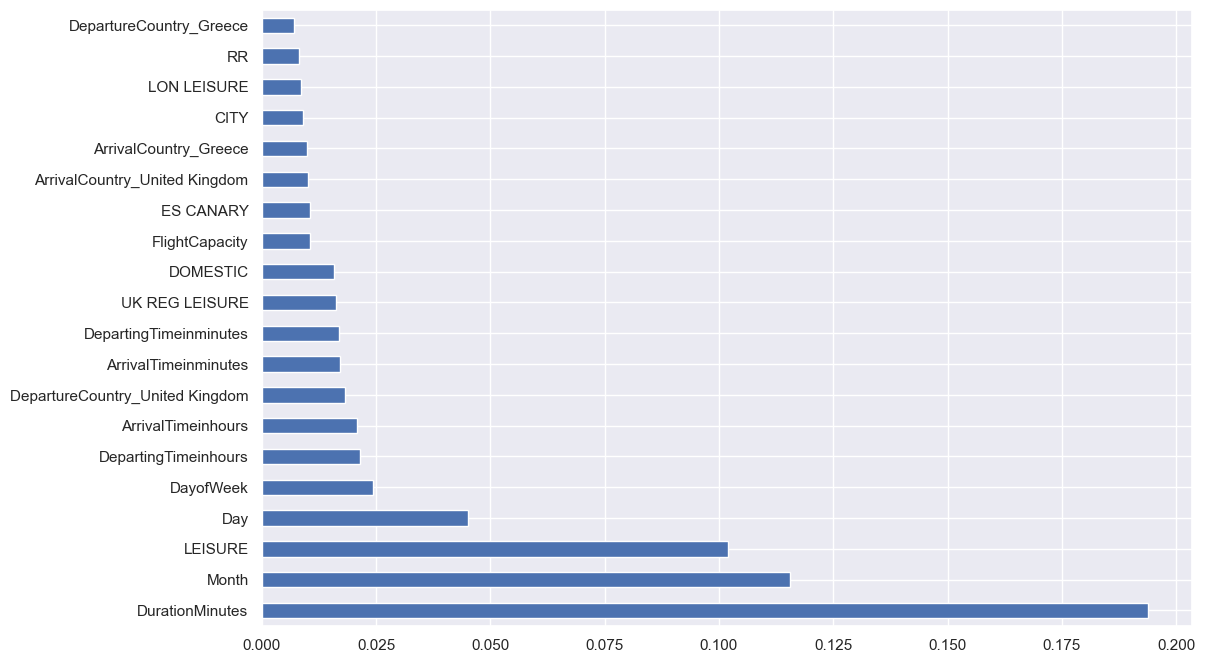

In [48]:
###
#Lastly for the 2nd section of the code (EDA and Feature Engineering), I want to take note of the important features
#This is done by determing to what extent the feature is related to the y value
# * I have only done this measurement against the Total Ancillary Revenue as this is the most important to predict
# * out of the y values
###

x = merged_df.iloc[:, 0:539]
y = merged_df['Total_Ancillary_Revenue']
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(x,y)
selection.feature_importances_
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = x.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()


In [49]:
###
# Last note before next section
# Originally I planned to remove the day, and deparute/arrival in minutes columns. However, it seems 
# that even though there feature importance is somewhat low it still ranks among the top ones. 
# So I'll leave it in. 
###

In [50]:
#Part 3
#Building Machine Learning Model
    # PCA
    # Random Forest Regression
    # Metrics 
#Validating Model
    # Results
#Visualizations
    #Comparing last year vs predictions

In [51]:
#RANDOM FOREST REGRESSION

In [52]:
############# PCA ########################
# Something that can be noted is that there are over 500 features
# This is way too many because it will increase the performance time 
# So to resolve this I'll incoporate Principal Component Analysis 
# This will convert the many features into only a couple 
# hopefully reducing unneccesary columns while still factoring in the important features

In [53]:
###
#Set the PCA acceptance to 99%
#Meaning that only features that have more than 1% signifigance will be included 
###

pca = PCA(0.99)
X_pca = pca.fit_transform(x)
X_pca = pd.DataFrame(data = X_pca)
pca_list = []
for col in X_pca.columns:
    pca_list.append('PCA '+str(int(col)+1))
    
X_pca.columns = pca_list   
X_pca.head()

###
#So effectively I've changed the X dataset 
#PCA can be seen as lumping the columns together
###

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5
0,31.817178,-14.407031,-10.919165,-13.728833,8.832181
1,31.995505,28.255450,3.350629,12.223016,-5.131814
2,32.063239,-14.172466,17.590692,7.065552,-0.817645
3,32.132407,-14.121116,24.661901,9.032369,-5.022662
4,31.853478,-14.393514,-10.724866,4.264726,9.039373


In [54]:
###
# This shows the importance of each PCA column 
# PCA 1 plays by far the most significant role with making up 70.5% 
###
pca.explained_variance_ratio_

array([0.70585508, 0.12287397, 0.11202652, 0.03018411, 0.01951082])

In [55]:
###
# Training and Testing will be performed below 
# It is done inside a for loop so that the random forest tree can predict against the 8 y values we care about
# 'Passenger_UnitsSold','Priority_Boarding_UnitsSold','Priority_Boarding_RevenueEUR','20KG_Bag_UnitsSold','20KG_Bag_RevenueEUR','10KG_Bag_UnitsSold','10KG_Bag_RevenueEUR','Total_Ancillary_Revenue'
# After each Y value is predicted then some print statements execute returning important metrics 
###

start_time = time.time()
dataset = pd.DataFrame([])

list3 = ['Passenger_UnitsSold','Priority_Boarding_UnitsSold','Priority_Boarding_RevenueEUR','20KG_Bag_UnitsSold','20KG_Bag_RevenueEUR','10KG_Bag_UnitsSold','10KG_Bag_RevenueEUR','Total_Ancillary_Revenue']

for i in list3:

    x_train, x_test, y_train, y_test = tts(X_pca, merged_df[i], test_size = 0.15, random_state = 40)
    #-----
    model_random_forest = RandomForestRegressor(n_estimators = 500, max_depth = 7, min_samples_split = 3)
    model_random_forest.fit(x_train, y_train)
    pred_rf = model_random_forest.predict(x_test)
    temp_df = pd.DataFrame({'Predicted'+i: pred_rf, 'Actual'+i: y_test}, columns=['Predicted'+i, 'Actual'+i])
    dataset = pd.concat([dataset, temp_df ], axis=1)
    
    #-----
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred_rf))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred_rf))
    print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, pred_rf, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, pred_rf))
    print('Explained Variance Score:', metrics.explained_variance_score(y_test, pred_rf))
    print('Max Error:', metrics.max_error(y_test, pred_rf))
    print('Median Absolute Error:', metrics.median_absolute_error(y_test, pred_rf))
    print('R^2:', metrics.r2_score(y_test, pred_rf))
    
    #-----
    print(i)
    print('---------------------------')
print("--- %s seconds ---" % (time.time() - start_time))

Mean Absolute Error (MAE): 13.186546945067061
Mean Squared Error (MSE): 496.1241433596681
Root Mean Squared Error (RMSE): 22.273844377647702
Mean Absolute Percentage Error (MAPE): 0.10865124470747686
Explained Variance Score: 0.02809099845419949
Max Error: 165.37791538579947
Median Absolute Error: 8.722935777587793
R^2: 0.028020395038772072
Passenger_UnitsSold
---------------------------
Mean Absolute Error (MAE): 8.443115030304202
Mean Squared Error (MSE): 118.42288581630038
Root Mean Squared Error (RMSE): 10.882227980349446
Mean Absolute Percentage Error (MAPE): 458372899789754.75
Explained Variance Score: 0.03696798765446241
Max Error: 68.48280706125416
Median Absolute Error: 6.777759744321198
R^2: 0.036865600728119396
Priority_Boarding_UnitsSold
---------------------------
Mean Absolute Error (MAE): 145.12872306961518
Mean Squared Error (MSE): 35016.87532727161
Root Mean Squared Error (RMSE): 187.12796511283827
Mean Absolute Percentage Error (MAPE): 7543295404689561.0
Explained Var

In [56]:
###
#The dataframe named Dataset has the tested results of the model next to the actual results 
###
dataset.head()

,PredictedPassenger_UnitsSold,ActualPassenger_UnitsSold,PredictedPriority_Boarding_UnitsSold,ActualPriority_Boarding_UnitsSold,PredictedPriority_Boarding_RevenueEUR,ActualPriority_Boarding_RevenueEUR,Predicted20KG_Bag_UnitsSold,Actual20KG_Bag_UnitsSold,Predicted20KG_Bag_RevenueEUR,Actual20KG_Bag_RevenueEUR,Predicted10KG_Bag_UnitsSold,Actual10KG_Bag_UnitsSold,Predicted10KG_Bag_RevenueEUR,Actual10KG_Bag_RevenueEUR,PredictedTotal_Ancillary_Revenue,ActualTotal_Ancillary_Revenue
6484,179.138202,193.0,38.481909,40.0,631.880178,619.50,45.015829,40.0,1827.935109,1384.64,9.600139,5.0,217.684025,119.96,2699.715508,2124.10
8585,180.443005,190.0,35.409697,42.0,602.761434,674.50,22.195565,21.0,803.949876,631.79,8.924589,7.0,200.170603,142.44,1619.257190,1448.73
2907,177.222627,189.0,33.590949,43.0,536.935665,704.23,20.954615,13.0,732.947311,440.87,9.104817,9.0,191.089777,156.47,1414.814929,1301.57
11540,182.299297,190.0,32.967661,33.0,523.548295,447.00,19.168472,18.0,546.911421,434.36,8.744679,6.0,159.080976,91.41,1247.751856,972.77
15217,181.331913,179.0,33.156055,25.0,538.595383,400.00,18.820336,37.0,552.336578,859.63,8.805042,16.0,171.300554,226.93,1300.702386,1486.56


In [57]:
###
#Summing all the columns together we see that in the aggregate that the predicted results are 
# quite close to the real values
###
dataset.sum()

PredictedPassenger_UnitsSold             4.120996e+05
ActualPassenger_UnitsSold                4.125370e+05
PredictedPriority_Boarding_UnitsSold     7.616349e+04
ActualPriority_Boarding_UnitsSold        7.642200e+04
PredictedPriority_Boarding_RevenueEUR    1.236900e+06
ActualPriority_Boarding_RevenueEUR       1.238874e+06
Predicted20KG_Bag_UnitsSold              4.754720e+04
Actual20KG_Bag_UnitsSold                 4.776800e+04
Predicted20KG_Bag_RevenueEUR             1.559805e+06
Actual20KG_Bag_RevenueEUR                1.579873e+06
Predicted10KG_Bag_UnitsSold              1.931398e+04
Actual10KG_Bag_UnitsSold                 1.949400e+04
Predicted10KG_Bag_RevenueEUR             3.983635e+05
Actual10KG_Bag_RevenueEUR                4.055227e+05
PredictedTotal_Ancillary_Revenue         3.196341e+06
ActualTotal_Ancillary_Revenue            3.224269e+06
dtype: float64

In [58]:
###
#The purpose of the dataframe Difference is to quickly see the total difference 
#between the predicted and real values. Helps to see at a high level.
###

difference_columns = ['Passenger_UnitsSold','Priority_Boarding_UnitsSold','Priority_Boarding_RevenueEUR',
                      '20KG_Bag_UnitsSold','20KG_Bag_RevenueEUR', '10KG_Bag_UnitsSold','10KG_Bag_RevenueEUR',
                     'Total_Ancillary_Revenue']
difference = pd.DataFrame(columns = difference_columns)
difference['Passenger_UnitsSold'] = dataset['PredictedPassenger_UnitsSold'] - dataset['ActualPassenger_UnitsSold'] 
difference['Priority_Boarding_UnitsSold'] = dataset['PredictedPriority_Boarding_UnitsSold'] - dataset['ActualPriority_Boarding_UnitsSold']
difference['Priority_Boarding_RevenueEUR'] = dataset['PredictedPriority_Boarding_RevenueEUR'] - dataset['ActualPriority_Boarding_RevenueEUR']
difference['20KG_Bag_UnitsSold'] = dataset['Predicted20KG_Bag_UnitsSold'] - dataset['Actual20KG_Bag_UnitsSold']
difference['20KG_Bag_RevenueEUR'] = dataset['Predicted20KG_Bag_RevenueEUR'] - dataset['Actual20KG_Bag_RevenueEUR']
difference['10KG_Bag_UnitsSold'] = dataset['Predicted10KG_Bag_UnitsSold'] - dataset['Actual10KG_Bag_UnitsSold']
difference['10KG_Bag_RevenueEUR'] = dataset['Predicted10KG_Bag_RevenueEUR'] - dataset['Actual10KG_Bag_RevenueEUR']
difference['Total_Ancillary_Revenue'] = dataset['PredictedTotal_Ancillary_Revenue'] - dataset['ActualTotal_Ancillary_Revenue']

difference.loc['Total Difference'] = difference[difference_columns].sum()


difference.tail(1)

,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR,Total_Ancillary_Revenue
Total Difference,-437.383036,-258.511043,-1973.96443,-220.796868,-20068.328625,-180.020217,-7159.191915,-27928.706869


In [59]:
###
#The transformation to PCA values meant that we lost our data and time references. 
#So I want to return the date and time factors so I reproduce the x_test dataframe but without the PCA altered data 
###
x_train_backup, x_test_backup, y_train_backup, y_test_backup = tts(merged_df.iloc[:, 0:539], merged_df[i], test_size = 0.15, random_state = 40)
final = pd.concat([x_test_backup, dataset ], axis=1)
final['Time'] = pd.to_datetime(final[['Year', 'Month', 'Day']])
final = final.groupby(final.Time.dt.date).sum()
final.reset_index(inplace=True)
final = final.drop(final.iloc[:, 1:540],axis = 1)
final.head()

,Time,PredictedPassenger_UnitsSold,ActualPassenger_UnitsSold,PredictedPriority_Boarding_UnitsSold,ActualPriority_Boarding_UnitsSold,PredictedPriority_Boarding_RevenueEUR,ActualPriority_Boarding_RevenueEUR,Predicted20KG_Bag_UnitsSold,Actual20KG_Bag_UnitsSold,Predicted20KG_Bag_RevenueEUR,Actual20KG_Bag_RevenueEUR,Predicted10KG_Bag_UnitsSold,Actual10KG_Bag_UnitsSold,Predicted10KG_Bag_RevenueEUR,Actual10KG_Bag_RevenueEUR,PredictedTotal_Ancillary_Revenue,ActualTotal_Ancillary_Revenue
0,2022-04-01,3335.834372,2724.0,625.026348,375.0,10126.536884,6148.35,372.500077,172.0,12421.126109,5215.06,157.429695,120.0,3262.305284,2030.24,25634.565219,13393.65
1,2022-04-02,2487.319272,2081.0,458.855430,315.0,7572.040071,5121.93,300.646612,240.0,10003.530188,7368.98,121.415232,94.0,2526.567213,1908.03,19993.483035,14398.94
2,2022-04-03,2839.032378,2445.0,519.948702,442.0,8435.958362,7133.73,344.073876,215.0,11379.335745,6064.30,133.575174,140.0,2808.278256,2839.95,22545.944209,16037.98
3,2022-04-04,1589.750008,1492.0,290.381460,296.0,4665.711217,4431.37,179.129461,98.0,5765.963774,2968.83,73.857784,57.0,1496.906762,1037.50,11954.265377,8437.70
4,2022-04-05,1936.058728,1615.0,359.221585,228.0,5825.908327,3751.09,235.789879,164.0,8062.257240,4622.61,92.276389,49.0,1888.402640,970.35,15442.988687,9344.05


Text(0, 0.5, 'Revenue')

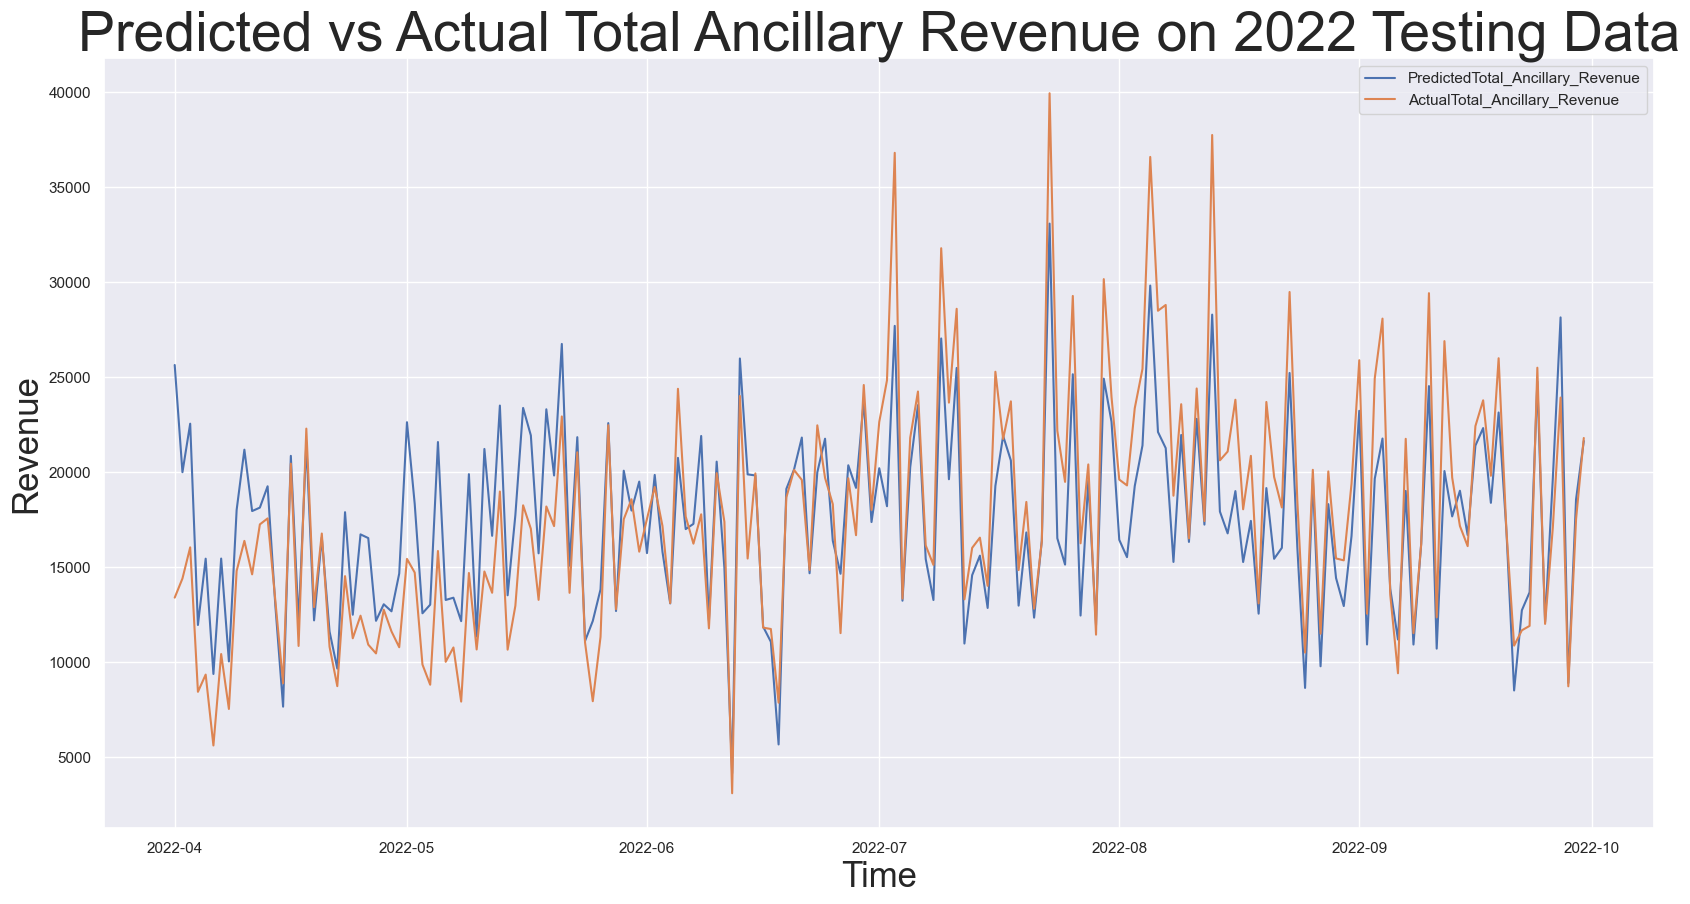

In [60]:
###
#quick graph plotting the predicted vs real values of the test set of 2022 flights
###
fig, ax = plt.subplots(figsize=(20,10)) 
final.plot(x = 'Time', y = 'PredictedTotal_Ancillary_Revenue', ax = ax) 
final.plot(x = 'Time', y = 'ActualTotal_Ancillary_Revenue', ax = ax, secondary_y = False) 
plt.title('Predicted vs Actual Total Ancillary Revenue on 2022 Testing Data', size = 40)
plt.xlabel('Time', size=25)
plt.ylabel('Revenue', size=25)

In [61]:
###
#Now we can apply the model to the validation set to predict this upcoming summer's ancillary revenue
#The process will be almost identical to the one above but this time it'll use the validation set instead of the merged
###

In [62]:
###
# Apply the PCA practice to the validation set 
# Only include the top 5 as that is what was used to build the training and testing set 
###

validation_dfx = validation_df.iloc[:,:539]
pca = PCA(5)
X_pca_validation = pca.fit_transform(validation_dfx)
X_pca_validation = pd.DataFrame(data = X_pca_validation)

#rename the columns 
pca_list = []
for col in X_pca_validation.columns:
    pca_list.append('PCA '+str(int(col)+1)) 
X_pca_validation.columns = pca_list   
X_pca_validation.head()


,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5
0,14.924522,21.718834,22.016020,-15.181393,-2.726354
1,14.924385,21.718746,22.015877,-15.181535,-2.726055
2,14.924432,21.718735,22.015430,-15.180868,-2.726009
3,14.924755,21.717771,22.014901,-15.181714,-2.723971
4,14.924522,21.718834,22.016020,-15.181393,-2.726354


In [63]:
###
#technically this isn't needed for the y because we aren't filling/using this part of the dataframe.
#however, it is good to go through the rythme and have the step noted. 
###

validation_dfy = validation_df.iloc[:,539:]
validation_dfy.head()

,Passenger_UnitsSold,Priority_Boarding_UnitsSold,Priority_Boarding_RevenueEUR,20KG_Bag_UnitsSold,20KG_Bag_RevenueEUR,10KG_Bag_UnitsSold,10KG_Bag_RevenueEUR,Total_Ancillary_Revenue
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [64]:
###
#Run the model against the validation set and the y variables I want to predict for 
###

start_time = time.time()
temp = pd.DataFrame([])
list3 = ['Passenger_UnitsSold','Priority_Boarding_UnitsSold','Priority_Boarding_RevenueEUR','20KG_Bag_UnitsSold','20KG_Bag_RevenueEUR','10KG_Bag_UnitsSold','10KG_Bag_RevenueEUR','Total_Ancillary_Revenue']

for i in list3:
#     x = merged_df.iloc[:, 0:539]
#     y = merged_df[i]
    #x_train, x_test, y_train, y_test = tts(x, y, test_size = 0.15, random_state = 40)
    x_train, x_test, y_train, y_test = tts(X_pca, merged_df[i], test_size = 0.15, random_state = 40)
    
    #-----
    model_random_forest = RandomForestRegressor(n_estimators = 500, max_depth = 7, min_samples_split = 3)
    model_random_forest.fit(x_train, y_train)
    pred_rf = model_random_forest.predict(X_pca_validation)
    
    temp_df = pd.DataFrame({'Predicted'+i: pred_rf}, columns=['Predicted'+i])
    temp = pd.concat([temp, temp_df ], axis=1)
    print(i)
print("--- %s seconds ---" % (time.time() - start_time))

Passenger_UnitsSold
Priority_Boarding_UnitsSold
Priority_Boarding_RevenueEUR
20KG_Bag_UnitsSold
20KG_Bag_RevenueEUR
10KG_Bag_UnitsSold
10KG_Bag_RevenueEUR
Total_Ancillary_Revenue
--- 152.35416460037231 seconds ---


In [65]:
###
#Quick look at the total sums of each y variable
###
temp.append(temp.sum(numeric_only=True), ignore_index=True).tail(1)

,PredictedPassenger_UnitsSold,PredictedPriority_Boarding_UnitsSold,PredictedPriority_Boarding_RevenueEUR,Predicted20KG_Bag_UnitsSold,Predicted20KG_Bag_RevenueEUR,Predicted10KG_Bag_UnitsSold,Predicted10KG_Bag_RevenueEUR,PredictedTotal_Ancillary_Revenue
1924,340053.857916,64546.798477,1.068821e+06,41803.0315,1.415235e+06,17049.49577,360317.678899,2.757161e+06


In [66]:
###
#join the results with the original validation df 
###

validation_predictions = pd.concat([backup_validation, temp ], axis=1)
validation_predictions

,InventoryLegSK,CarrierCode,FlightNumber,DepartureAirport,ArrivalAirport,DepartureDateTimeLocal,DepartureDateTimeUTC,ArrivalDateTimeLocal,ArrivalDateTimeUTC,ArrivalCountry,DepartureCountry,RouteGroup,Region,FlightCapacity,PredictedPassenger_UnitsSold,PredictedPriority_Boarding_UnitsSold,PredictedPriority_Boarding_RevenueEUR,Predicted20KG_Bag_UnitsSold,Predicted20KG_Bag_RevenueEUR,Predicted10KG_Bag_UnitsSold,Predicted10KG_Bag_RevenueEUR,PredictedTotal_Ancillary_Revenue
0,8916818,FR,9898,LPL,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,174.721604,37.155273,616.453218,24.752528,958.128696,8.826597,201.501076,1629.849524
1,8917570,FR,9094,MAN,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,174.721604,37.155273,616.453218,24.752528,958.128696,8.826597,201.501076,1629.849524
2,8917600,FR,8296,BRS,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,174.721604,37.155273,616.453218,24.752528,958.128696,8.826597,201.501076,1629.849524
3,8917836,FR,7544,MAN,BCN,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,174.721604,37.155273,616.453218,24.752528,958.128696,8.826597,201.501076,1629.849524
4,8918208,FR,9898,LPL,ALC,2023-04-30 10:10:00,2023-04-30 09:10:00,2023-04-30 13:55:00,2023-04-30 11:55:00,Spain,United Kingdom,LEISURE,UK REG LEISURE,189,174.721604,37.155273,616.453218,24.752528,958.128696,8.826597,201.501076,1629.849524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,9744821,FR,4929,FCO,CTA,2023-07-11 05:45:00,2023-07-11 04:45:00,2023-07-11 09:45:00,2023-07-11 07:45:00,Italy,Italy,DOMESTIC,ROM DOM,189,181.191980,35.578386,611.328691,24.636475,891.832252,8.957767,203.132069,1720.443764
1920,9745290,FR,4930,CTA,FCO,2023-07-11 05:45:00,2023-07-11 04:45:00,2023-07-11 09:45:00,2023-07-11 07:45:00,Italy,Italy,DOMESTIC,ROM DOM,189,181.191980,35.578386,611.328691,24.636475,891.832252,8.957767,203.132069,1720.443764
1921,9746110,FR,4929,FCO,CTA,2023-07-11 05:45:00,2023-07-11 04:45:00,2023-07-11 09:45:00,2023-07-11 07:45:00,Italy,Italy,DOMESTIC,ROM DOM,189,181.191980,35.578386,611.328691,24.636475,891.832252,8.957767,203.132069,1720.443764
1922,9857976,FR,488,VIE,PMI,2023-07-11 05:45:00,2023-07-11 04:45:00,2023-07-11 09:45:00,2023-07-11 07:45:00,Spain,Austria,LEISURE,DE LEISURE,180,181.180210,35.589443,611.544517,24.648951,892.939568,9.015082,211.411947,1724.379956


In [67]:
###
#save it to csv to submit
###
validation_predictions.to_csv(path+'validation_predictions.csv')

In [68]:
###
#Modify the dataset so y variables can be seen aggregated by day 
###
validation_predictions['DepartureDateTimeUTC'] = pd.to_datetime(validation_predictions.DepartureDateTimeUTC, format='%Y-%m-%d')
validation_predictions = pd.DataFrame(validation_predictions.groupby([validation_predictions['DepartureDateTimeUTC'].dt.date])['PredictedPassenger_UnitsSold','PredictedPriority_Boarding_UnitsSold','PredictedPriority_Boarding_RevenueEUR','Predicted20KG_Bag_UnitsSold','Predicted20KG_Bag_RevenueEUR','Predicted10KG_Bag_UnitsSold','Predicted10KG_Bag_RevenueEUR','PredictedTotal_Ancillary_Revenue'].sum())
validation_predictions = validation_predictions.reset_index()
validation_predictions

,DepartureDateTimeUTC,PredictedPassenger_UnitsSold,PredictedPriority_Boarding_UnitsSold,PredictedPriority_Boarding_RevenueEUR,Predicted20KG_Bag_UnitsSold,Predicted20KG_Bag_RevenueEUR,Predicted10KG_Bag_UnitsSold,Predicted10KG_Bag_RevenueEUR,PredictedTotal_Ancillary_Revenue
0,2023-04-08,10315.657213,2041.877207,34741.927661,1527.803916,56138.013205,486.701396,12214.640822,103039.493643
1,2023-04-18,10708.475564,2034.383638,33494.040836,1469.958931,49895.091868,558.971723,12456.871896,94814.560626
2,2023-04-30,14005.083653,2947.313283,49028.212082,1990.164161,76986.284549,706.227873,16120.214028,130457.815240
3,2023-05-03,11158.981519,2184.245456,37977.000063,1457.644692,51863.700505,562.544722,13756.245757,101779.812748
4,2023-05-04,11603.630915,2111.408740,33399.287260,1077.261676,29719.627129,547.000031,9842.436119,72933.036988
5,2023-05-23,10893.642691,2135.691571,33924.925490,1284.744027,53710.163620,448.877487,10494.094910,94009.931168
6,2023-05-27,26339.632709,4764.249634,79513.915589,2804.502728,87648.395121,1315.250327,26579.383036,190881.169408
7,2023-06-07,14235.247231,2644.309343,43943.698646,1543.399854,47808.252116,704.051781,14523.865000,105802.948934
8,2023-06-20,12150.697132,2394.907193,41286.608793,1656.283323,59816.393547,605.653702,14003.099521,115707.547324
9,2023-07-11,10146.810918,1992.365406,34231.096905,1379.663108,49940.662515,501.464721,11383.859964,96356.768356


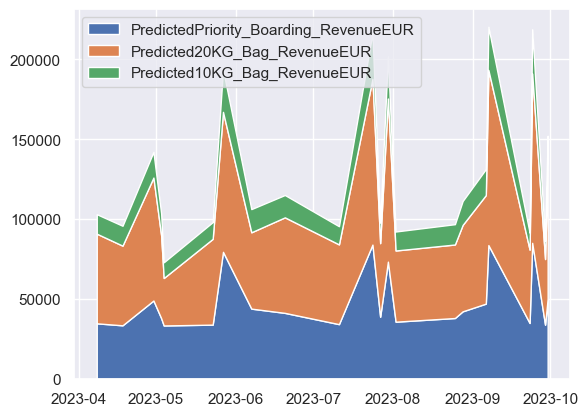

In [69]:
###
# Stacked line graph to show the components of the revenue
###
# Your x and y axis
x=validation_predictions['DepartureDateTimeUTC']
y=[validation_predictions['PredictedPriority_Boarding_RevenueEUR'], validation_predictions['Predicted20KG_Bag_RevenueEUR'],
  validation_predictions['Predicted10KG_Bag_RevenueEUR']]

# Basic stacked area chart.
plt.stackplot(x,y, labels=['PredictedPriority_Boarding_RevenueEUR','Predicted20KG_Bag_RevenueEUR','Predicted10KG_Bag_RevenueEUR'])
plt.legend(loc='upper left')
plt.show()


Text(0.5, 1.0, 'Ancillary Revenue of Ryanair 2023')

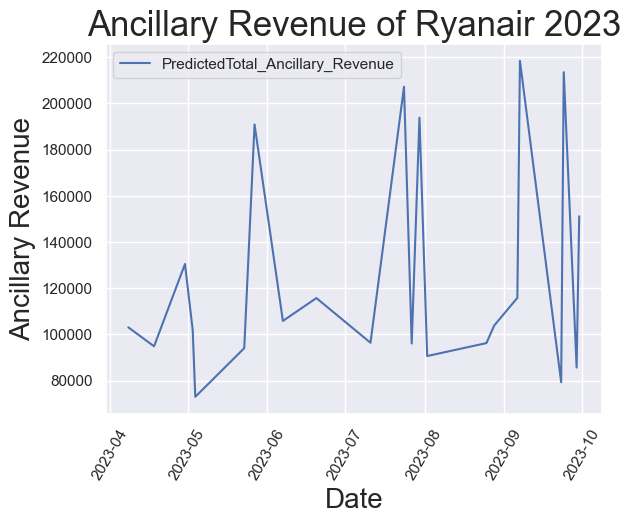

In [70]:
###
# timeseries plot of what can be expected for the upcoming summer based of the datasets provided
###
validation_predictions.plot(x="DepartureDateTimeUTC", y="PredictedTotal_Ancillary_Revenue")
plt.xlabel("Date",  size = 20)
plt.xticks(rotation=60)
plt.ylabel("Ancillary Revenue", size = 20)
plt.title("Ancillary Revenue of Ryanair 2023", size = 25)

In [71]:
print("--- %s seconds ---" % (time.time() - original_start_time))

--- 425.9002010822296 seconds ---
